In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import math

%matplotlib inline

In [24]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

In [4]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "rb") as picklefile:
    MI_mortality_per_state_dict = pickle.load(picklefile)

In [5]:
with open("../data/pickles/dict_of_interpol_covariate_state_dfs.pkl", "rb") as picklefile:
    state_covariate_dfs_dict = pickle.load(picklefile)

In [6]:
master_dict_of_state_dfs = {}

for state, df in MI_mortality_per_state_dict.items():
    covariate_df = state_covariate_dfs_dict[state]
    temp_df = pd.merge(df, covariate_df, left_index=True, right_index=True)
    temp_df = temp_df.drop(columns=['Deaths', 'Population'])
    master_dict_of_state_dfs[state] = temp_df

In [7]:
with open("../data/pickles/master_dict_of_state_dfs_with_covariates.pkl", "wb") as f:
    pickle.dump(master_dict_of_state_dfs, f)

In [8]:
master_dict_of_state_dfs['California'].head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518  
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578  
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638  
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697  
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757

So now let's try running gridsearch with other models and seeing how it does. What we did with SARIMA and SARIMAX was to use the first 2/3 of the time series data on California as the training set, and then we saw how well it forecast into the future using the last 1/3 of the data that we held out as a test set. In order to run a similar procedure for one state's data (we'll use California again), we need to split the data again and run a gridsearch on the training set, and then see what the test MSE is for its forecast for the test set.

In [9]:
california_df = master_dict_of_state_dfs['California']

In [11]:
california_df.shape

(193, 13)

For this first round, we're not going to difference or add in the autoregression or moving average terms. First, we'll try running these models on the raw data.

Also, we will have to scale that data for the sake of the SVM model; the tree-based models can handle unscaled data.

In [76]:
train_fraction = 0.66

train_length = math.ceil(train_fraction*california_df.shape[0])

california_train = california_df.iloc[0:train_length, :]
california_X_train = california_train.drop(columns=['mortality_per_100k'])
california_y_train = california_train.mortality_per_100k

california_test = california_df.iloc[train_length:, :]
california_X_test = california_test.drop(columns=['mortality_per_100k'])
california_y_test = california_test.mortality_per_100k

In [77]:
# Now, let's fit and scale X_train, and then we'll also scale X_test.

california_columns = california_X_test.columns
california_train_index = california_X_train.index
california_test_index = california_X_test.index

ssx = StandardScaler()

california_X_train_scaled = ssx.fit_transform(california_X_train)
california_X_test_scaled = ssx.transform(california_X_test)

california_X_train_scaled = pd.DataFrame(california_X_train_scaled, columns=california_columns, index =california_train_index)
california_X_test_scaled = pd.DataFrame(california_X_test_scaled, columns=california_columns, index=california_test_index)

In [78]:
california_X_train_scaled.head()

obesity_prevalence  diabetes_prevalence  high_cholesterol  \
1999-01-01           -1.385006            -1.742864         -2.031234   
1999-02-01           -1.441534            -1.673604         -1.986244   
1999-03-01           -1.498062            -1.604344         -1.941254   
1999-04-01           -1.554589            -1.535084         -1.896264   
1999-05-01           -1.611117            -1.465824         -1.851274   

            hypertension  exercise  general_health  mental_health  coverage  \
1999-01-01     -1.485133 -1.522883       -1.108240      -1.919230  2.434914   
1999-02-01     -1.468757 -1.195110       -1.054284      -1.930002  2.359482   
1999-03-01     -1.452381 -0.867338       -1.000327      -1.940775  2.284051   
1999-04-01     -1.436006 -0.539565       -0.946371      -1.951547  2.208619   
1999-05-01     -1.419630 -0.211793       -0.892414      -1.962320  2.133188   

              income    smoker  med_cost    gender  
1999-01-01 -2.763472  1.946420 -1.760333  0.786302  
1999-02-01 -2.640139  1.872902 -1.669385  0.838846  
1999-03-01 -2.516805  1.799385 -1.578436  0.891390  
1999-04-01 -2.393472  1.725867 -1.487488  0.943933  
1999-05-01 -2.270139  1.652349 -1.396539  0.996477

In [79]:
models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
test_rmse = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    
    grid.fit(california_X_train_scaled, california_y_train)
    
    california_y_test_predict = grid.predict(california_X_test_scaled)
    
    test_mse_score = -1.0*grid.score(california_X_test_scaled, california_y_test)
    test_rmse_score = np.sqrt(test_mse_score)
    
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}\ntest rmse: {test_rmse_score}\n"
        
    grids[name] = grid
    test_rmse[name] = test_rmse_score
    
    print(f'Model name: {name}')
    print(s)

Model name: Linear Regresion
Linear Regresion: best score: -1.0301268298746013e+27, best estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
test rmse: 4698495651865.123

Model name: SVR
SVR: best score: -0.5661682887884255, best estimator: SVR(C=1.0990000000000002, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
test rmse: 1.5393814084231365

Model name: Decision Tree
Decision Tree: best score: -0.4121524433269845, best estimator: DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
test rmse: 0.6504151849240337

Model name: Random Forest
Random Forest: best score: -0.3894941880409134, best estimator: RandomFo

Let's see how these different models forecasted the target for the test set, and plot it out.

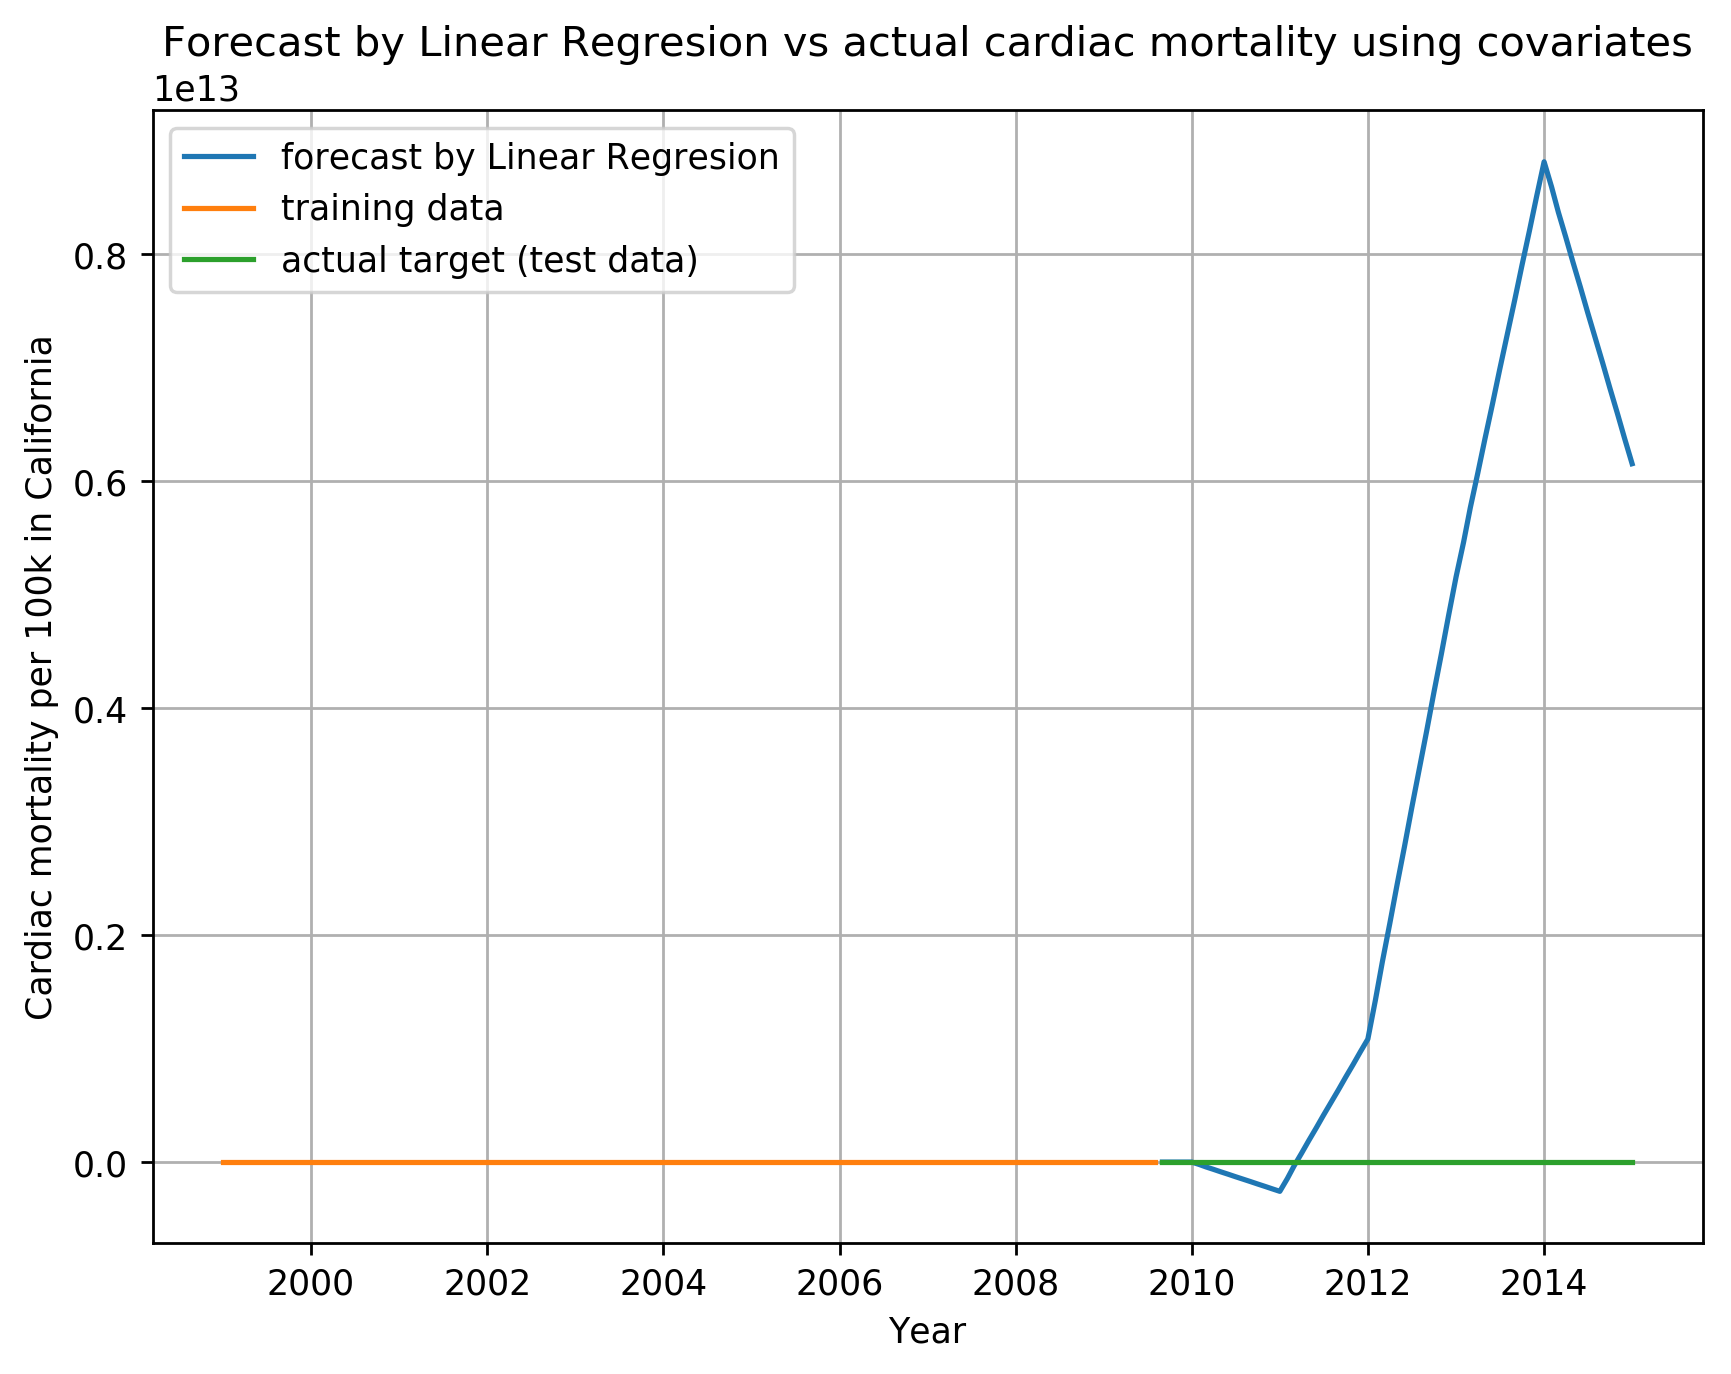

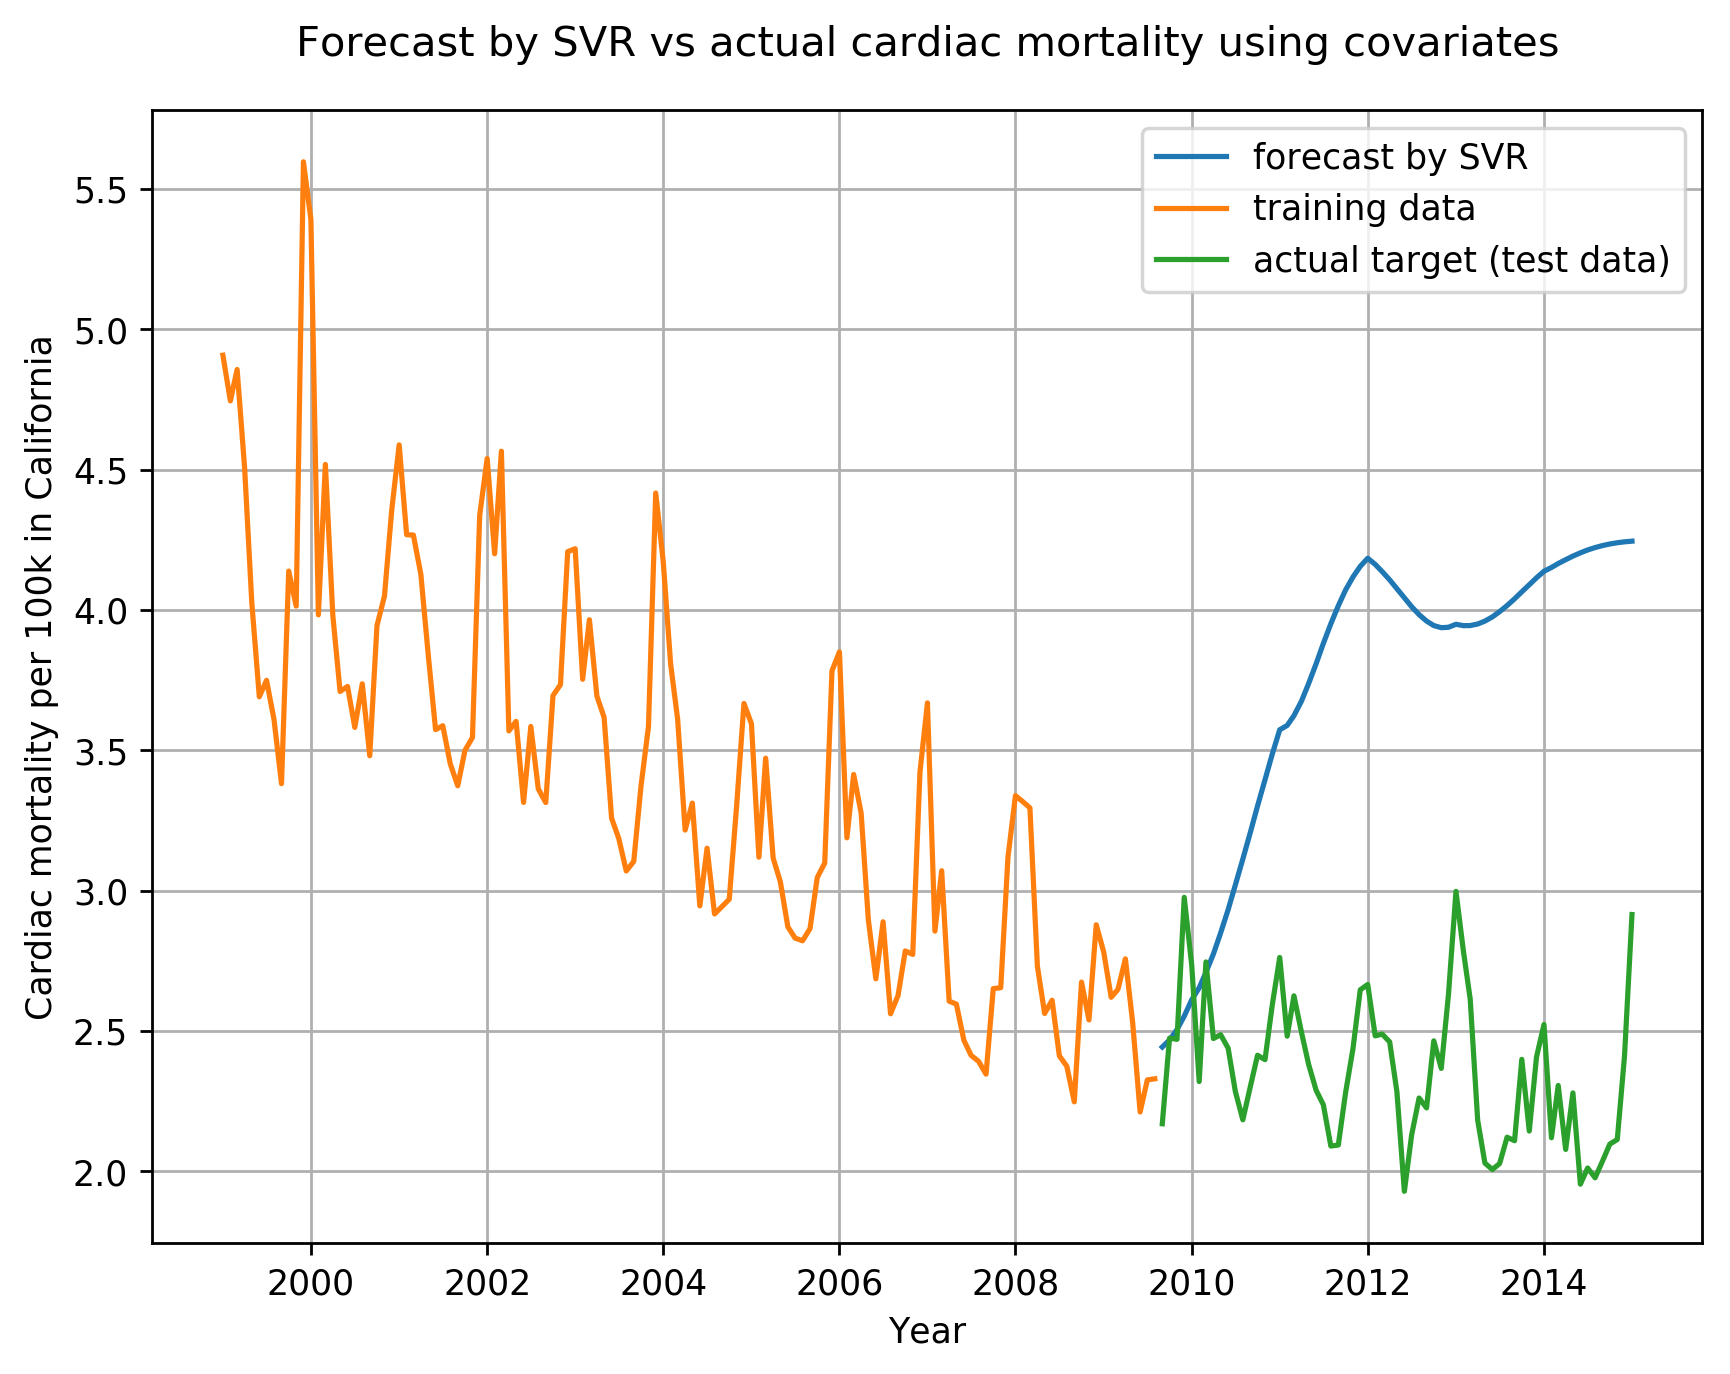

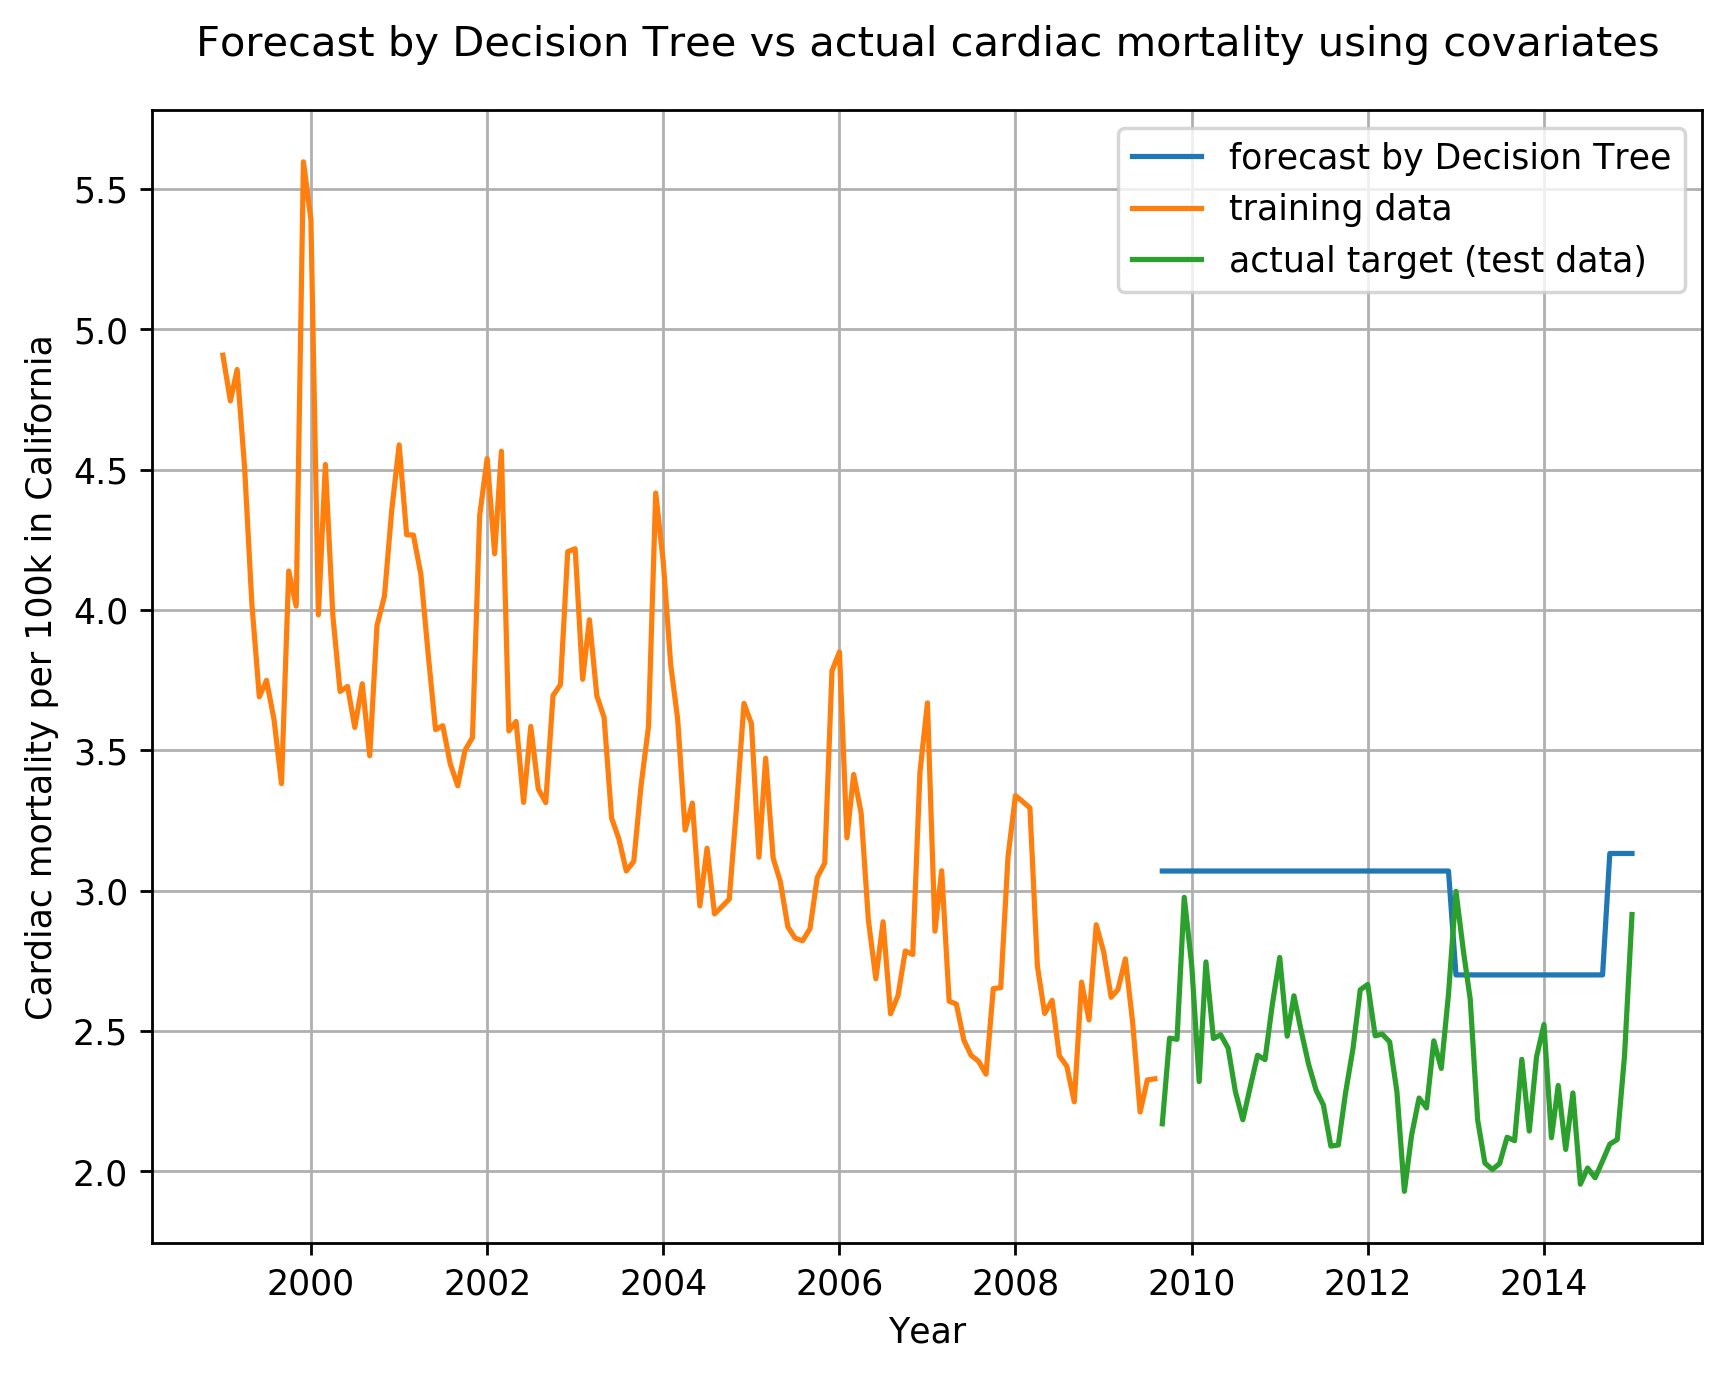

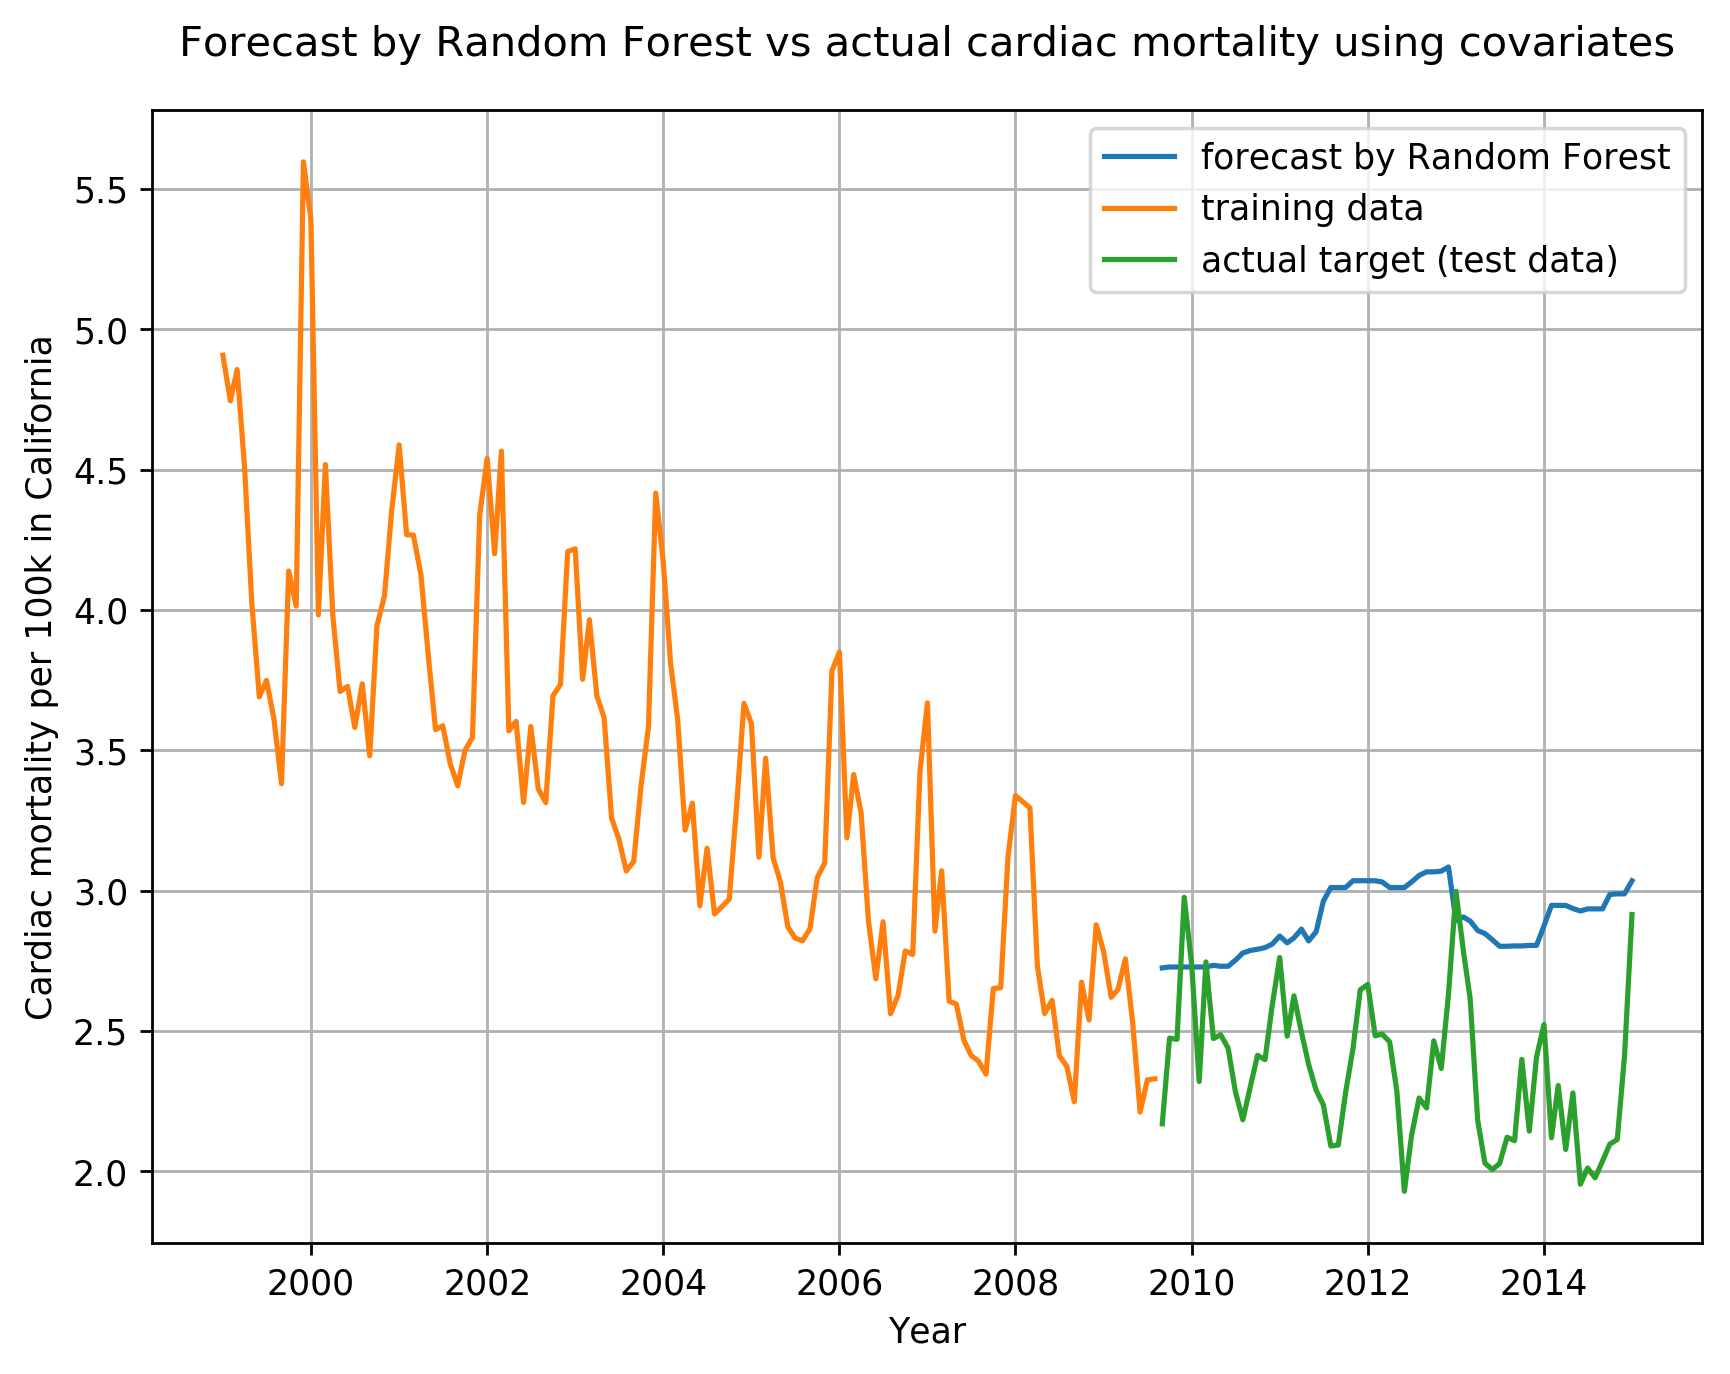

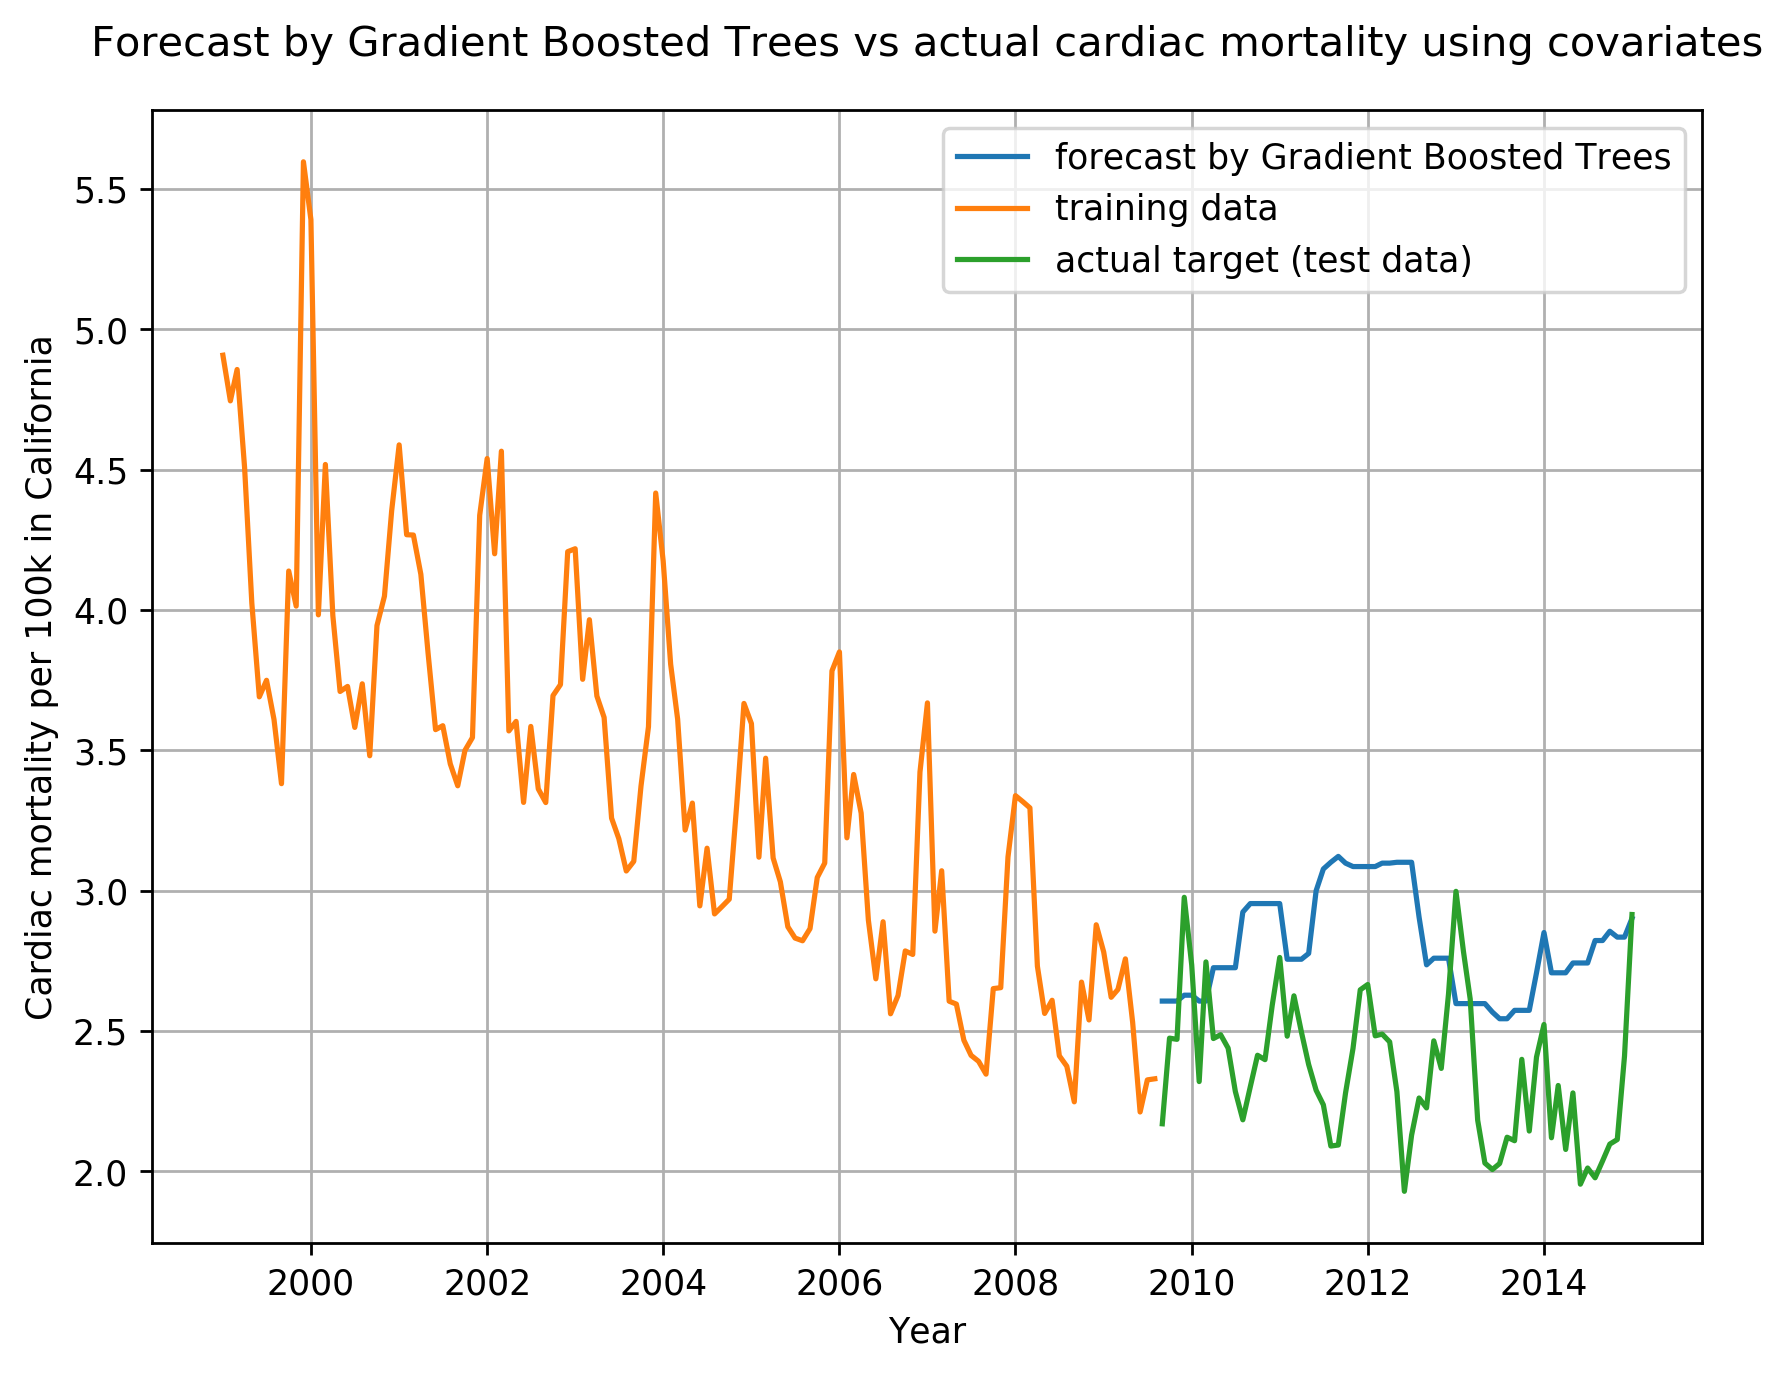

In [82]:
for model_name, model in grids.items():
    california_forecast = model.predict(california_X_test_scaled)
    california_forecast = pd.Series(california_forecast, index = california_y_test.index)

    plt.plot(california_forecast, label=f'forecast by {model_name}')
    plt.plot(california_y_train, label='training data')
    plt.plot(california_y_test, label='actual target (test data)')

    plt.xlabel('Year')
    plt.ylabel('Cardiac mortality per 100k in California')
    plt.title(f'Forecast by {model_name} vs actual cardiac mortality using covariates', y = 1.03)

    plt.grid()
    plt.legend()
    
    file_model_name = model_name.replace(" ", "_").lower()
    
    plt.savefig(f'../figures/california_forecast_{file_model_name}.png')
    plt.show()

Clearly, I am not capturing the seasonality of the target variable; I probably could if I added in a month or season variable, but instead I'll try adding in an AR1 and MA1, as well as a lag 12 (seasonal p of 1) and see if this improves the forecasting.

In [83]:
california_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518  
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578  
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638  
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697  
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757

In [84]:
california_SARMA_df = california_df.copy()
california_SARMA_df['mort_per_100k_lag1'] = california_SARMA_df['mortality_per_100k'].shift()
california_SARMA_df['mort_per_100k_lag_MA1'] = california_SARMA_df['mort_per_100k_lag1'].rolling(2).mean()
california_SARMA_df['mort_per_100k_seasonal_lag1'] = california_SARMA_df['mortality_per_100k'].shift(12)

In [85]:
california_SARMA_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  \
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518   
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578   
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638   
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697   
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757   

            mort_per_100k_lag1  mort_per_100k_lag_MA1  \
1999-01-01                 NaN                    NaN   
1999-02-01            4.907579                    NaN   
1999-03-01            4.744970               4.826275   
1999-04-01            4.856788               4.800879   
1999-05-01            4.506983               4.681885   

            mort_per_100k_seasonal_lag1  
1999-01-01                          NaN  
1999-02-01                          NaN  
1999-03-01                          NaN  
1999-04-01                          NaN  
1999-05-01                          NaN

We then have to drop the NaNs in order to run our models. This unfortunately means that we lose a year's worth of data from the beginning, since we included a S(p=1) term where m = 12.

In [86]:
california_SARMA_df.dropna(inplace=True)

In [87]:
california_SARMA_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
2000-01-01           39.200000             7.100000            5.390939   
2000-02-01           39.933333             7.058333            3.982631   
2000-03-01           40.666667             7.016667            4.518301   
2000-04-01           41.400000             6.975000            3.979591   
2000-05-01           42.133333             6.933333            3.709546   

            high_cholesterol  hypertension  exercise  general_health  \
2000-01-01          0.221622      0.230241  0.264730        0.166669   
2000-02-01          0.222507      0.230419  0.264122        0.166097   
2000-03-01          0.223392      0.230597  0.263515        0.165525   
2000-04-01          0.224278      0.230774  0.262907        0.164952   
2000-05-01          0.225163      0.230952  0.262299        0.164380   

            mental_health  coverage     income    smoker  med_cost    gender  \
2000-01-01       3.213513  0.183922  43.733065  0.172096  0.127796  0.496235   
2000-02-01       3.236311  0.181071  43.882558  0.172084  0.127898  0.496208   
2000-03-01       3.259110  0.178220  44.032052  0.172073  0.128001  0.496181   
2000-04-01       3.281908  0.175370  44.181546  0.172061  0.128103  0.496154   
2000-05-01       3.304706  0.172519  44.331040  0.172049  0.128206  0.496127   

            mort_per_100k_lag1  mort_per_100k_lag_MA1  \
2000-01-01            5.596826               4.805241   
2000-02-01            5.390939               5.493883   
2000-03-01            3.982631               4.686785   
2000-04-01            4.518301               4.250466   
2000-05-01            3.979591               4.248946   

            mort_per_100k_seasonal_lag1  
2000-01-01                     4.907579  
2000-02-01                     4.744970  
2000-03-01                     4.856788  
2000-04-01                     4.506983  
2000-05-01                     4.023989

In [88]:
train_fraction = 0.66

train_length = math.ceil(train_fraction*california_SARMA_df.shape[0])

california_train = california_SARMA_df.iloc[0:train_length, :]
california_X_train = california_train.drop(columns=['mortality_per_100k'])
california_y_train = california_train.mortality_per_100k

california_test = california_SARMA_df.iloc[train_length:, :]
california_X_test = california_test.drop(columns=['mortality_per_100k'])
california_y_test = california_test.mortality_per_100k

In [89]:
# Now, let's fit and scale X_train, and then we'll also scale X_test.

california_columns = california_X_test.columns
california_train_index = california_X_train.index
california_test_index = california_X_test.index

ssx = StandardScaler()

california_X_train_scaled = ssx.fit_transform(california_X_train)
california_X_test_scaled = ssx.transform(california_X_test)

california_X_train_scaled = pd.DataFrame(california_X_train_scaled, columns=california_columns, index =california_train_index)
california_X_test_scaled = pd.DataFrame(california_X_test_scaled, columns=california_columns, index=california_test_index)

In [90]:
models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
test_rmse = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    
    grid.fit(california_X_train_scaled, california_y_train)
    
    california_y_test_predict = grid.predict(california_X_test_scaled)
    
    test_mse_score = -1.0*grid.score(california_X_test_scaled, california_y_test)
    test_rmse_score = np.sqrt(test_mse_score)
    
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}\ntest rmse: {test_rmse_score}\n"
        
    grids[name] = grid
    test_rmse[name] = test_rmse_score
    
    print(f'Model name: {name}')
    print(s)

Model name: Linear Regresion
Linear Regresion: best score: -2.3802688234219048e+26, best estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
test rmse: 4946276120673.472

Model name: SVR
SVR: best score: -0.3108140424272185, best estimator: SVR(C=5.095000000000001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
test rmse: 1.337553060096148

Model name: Decision Tree
Decision Tree: best score: -0.15325045423356773, best estimator: DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
test rmse: 0.20168047265047476

Model name: Random Forest
Random Forest: best score: -0.11899738816859466, best estimator: RandomF

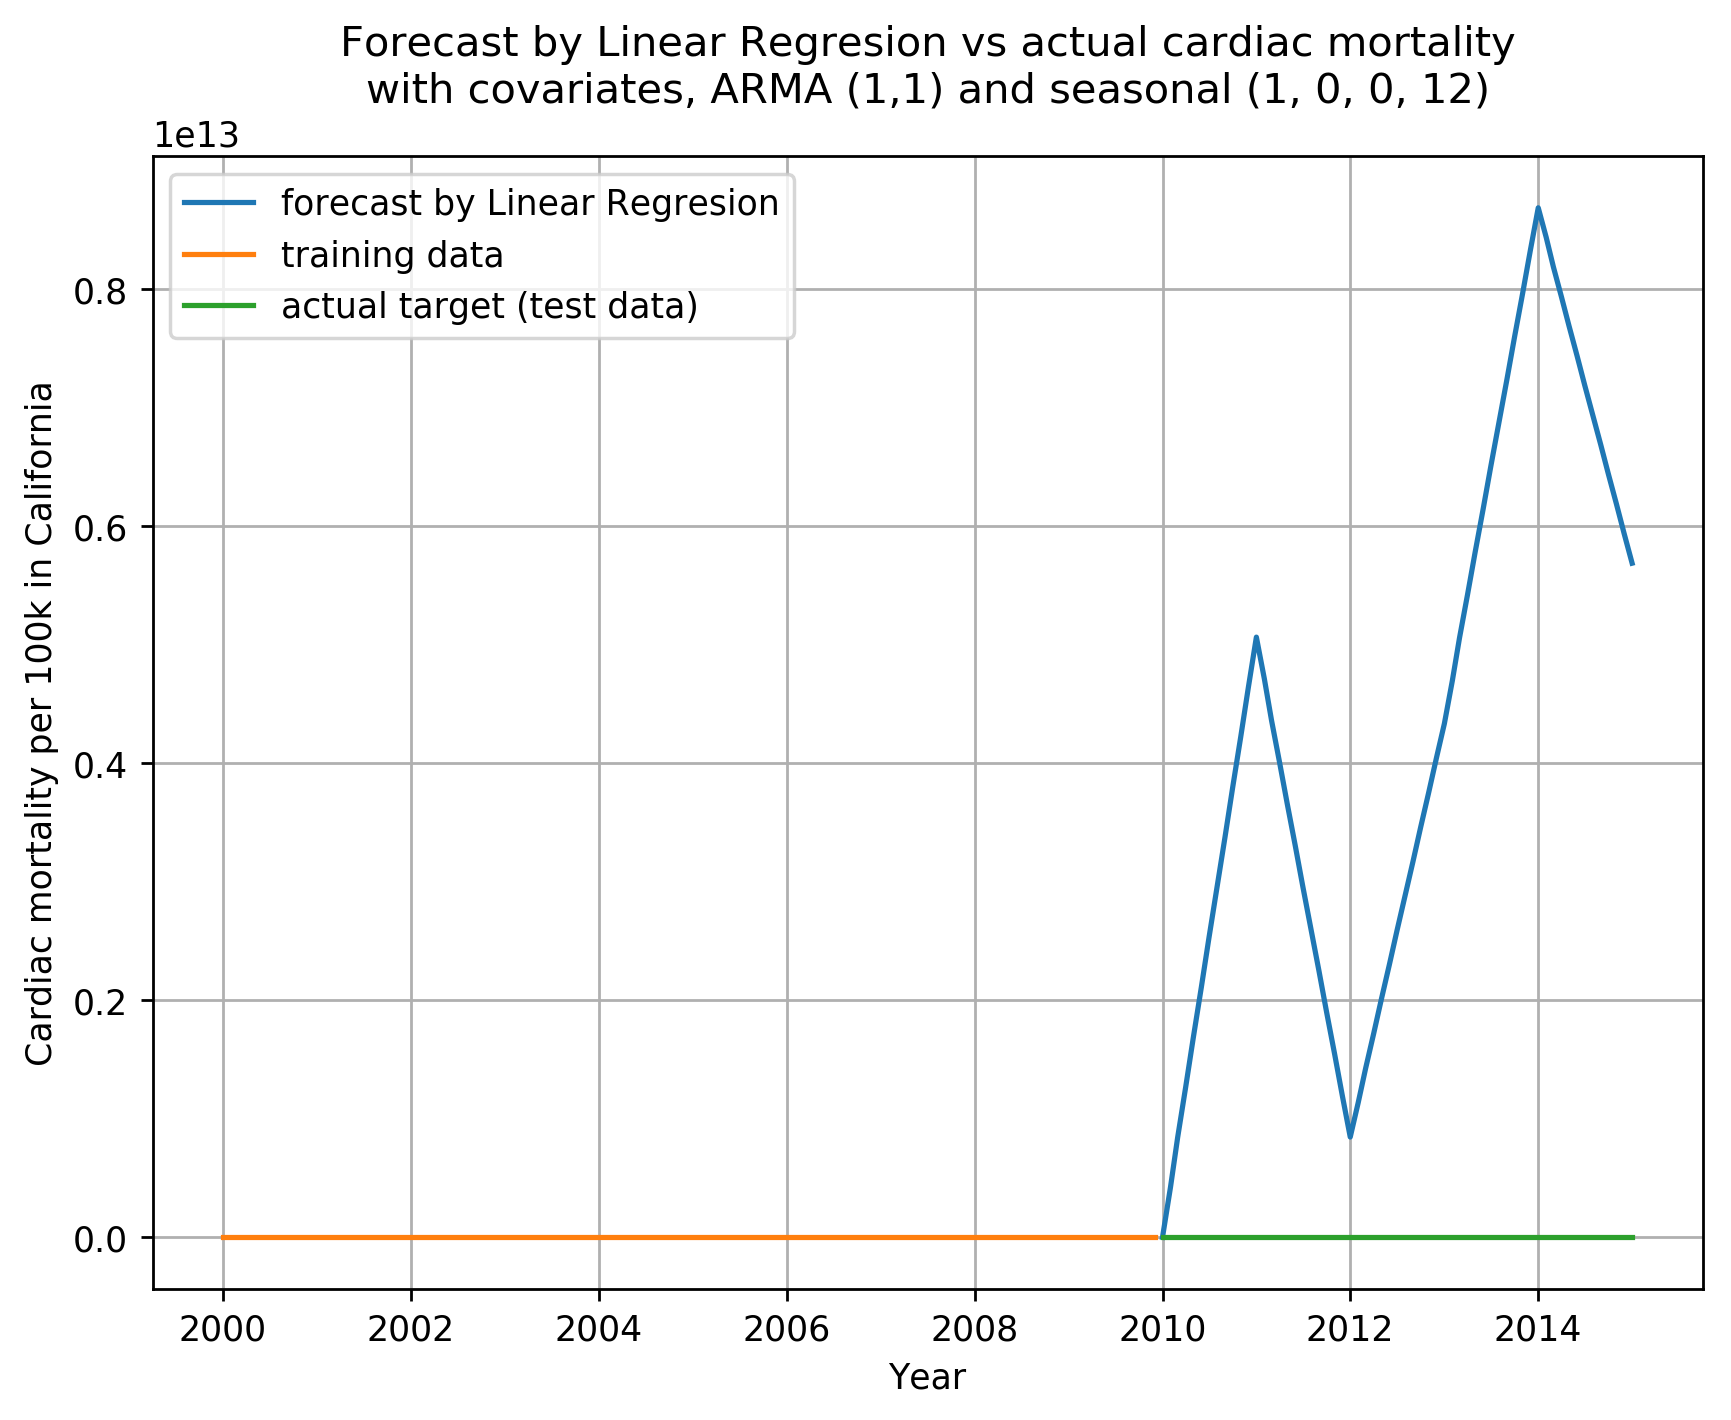

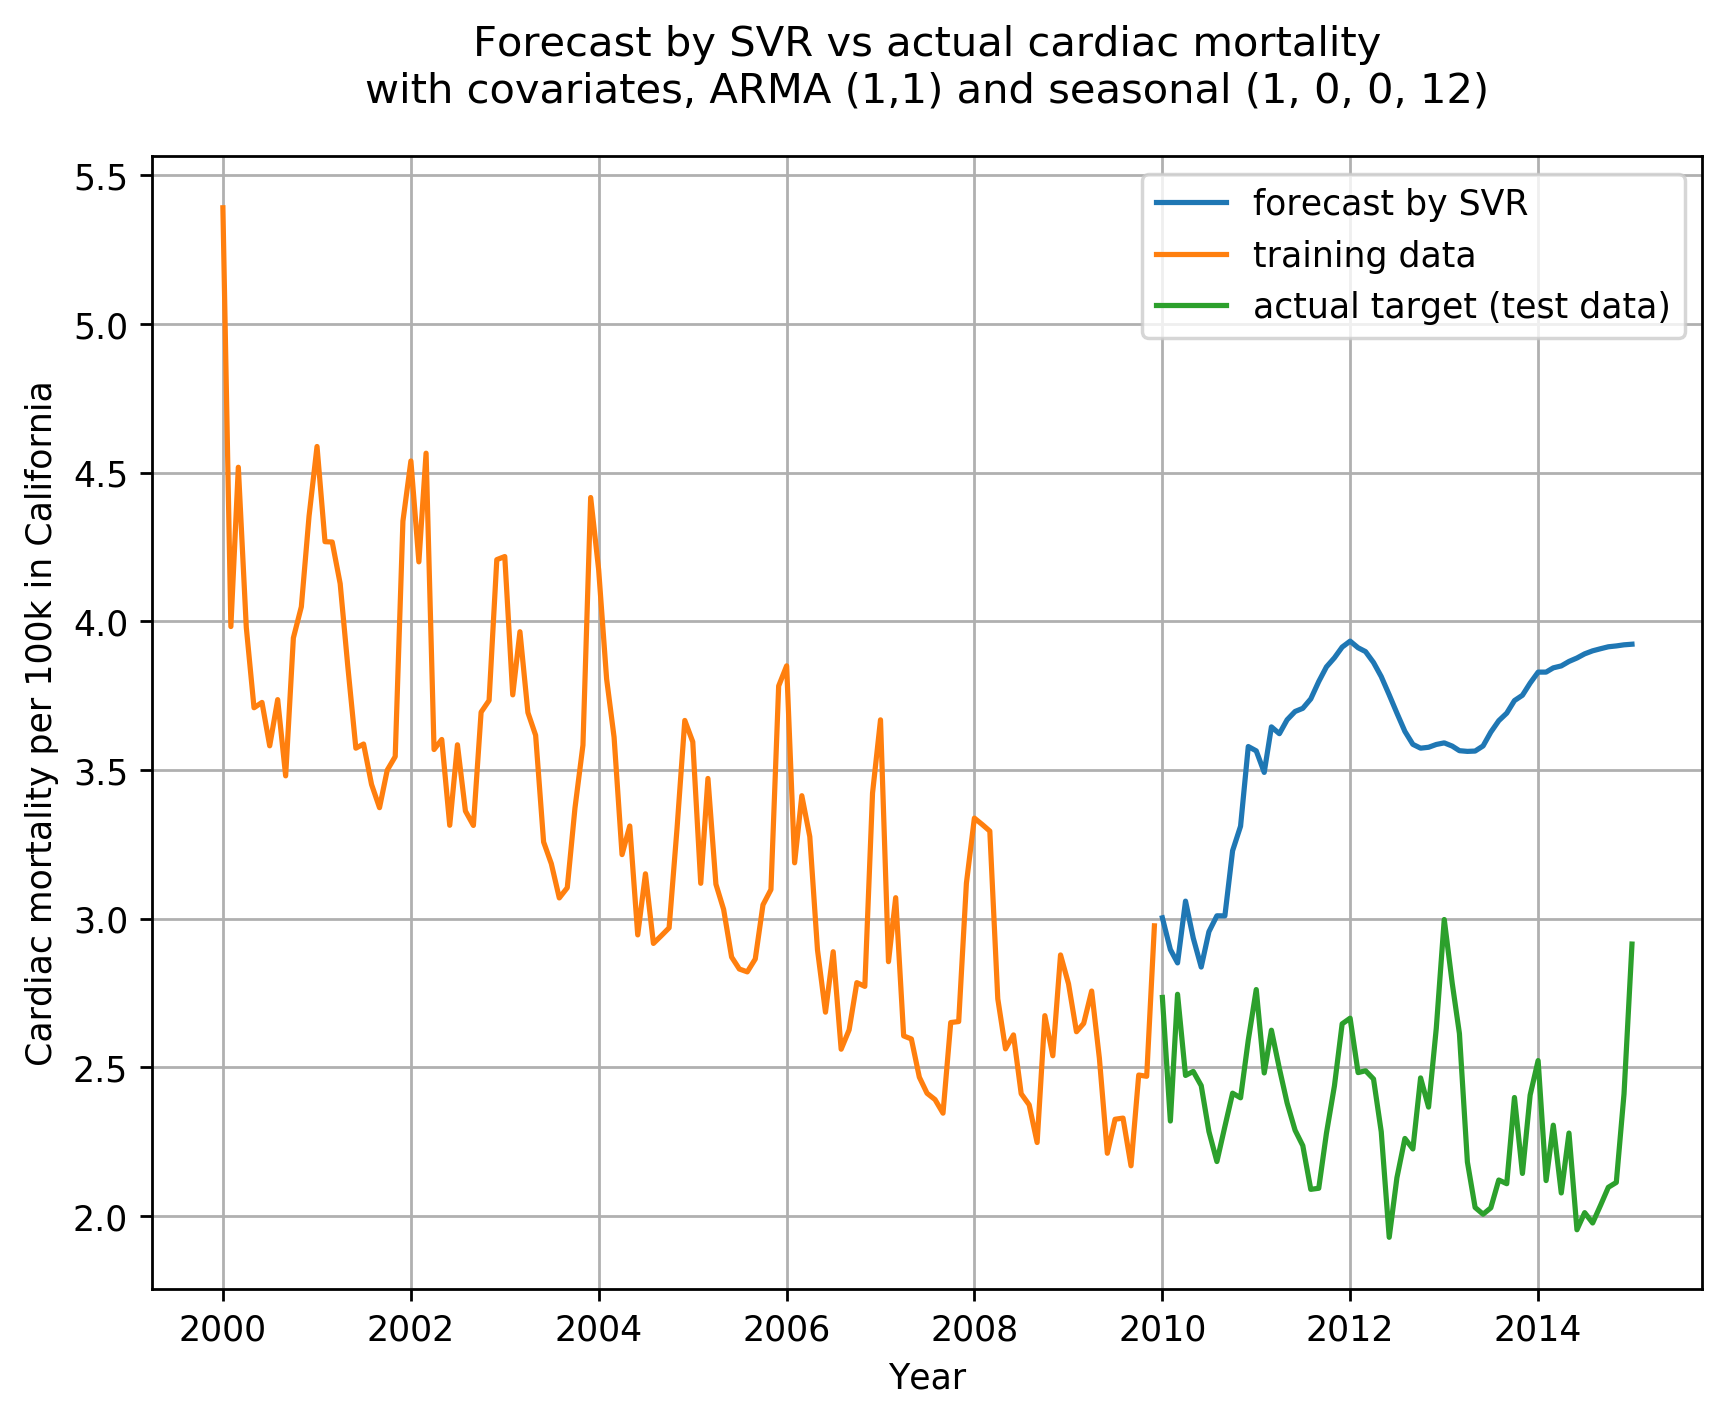

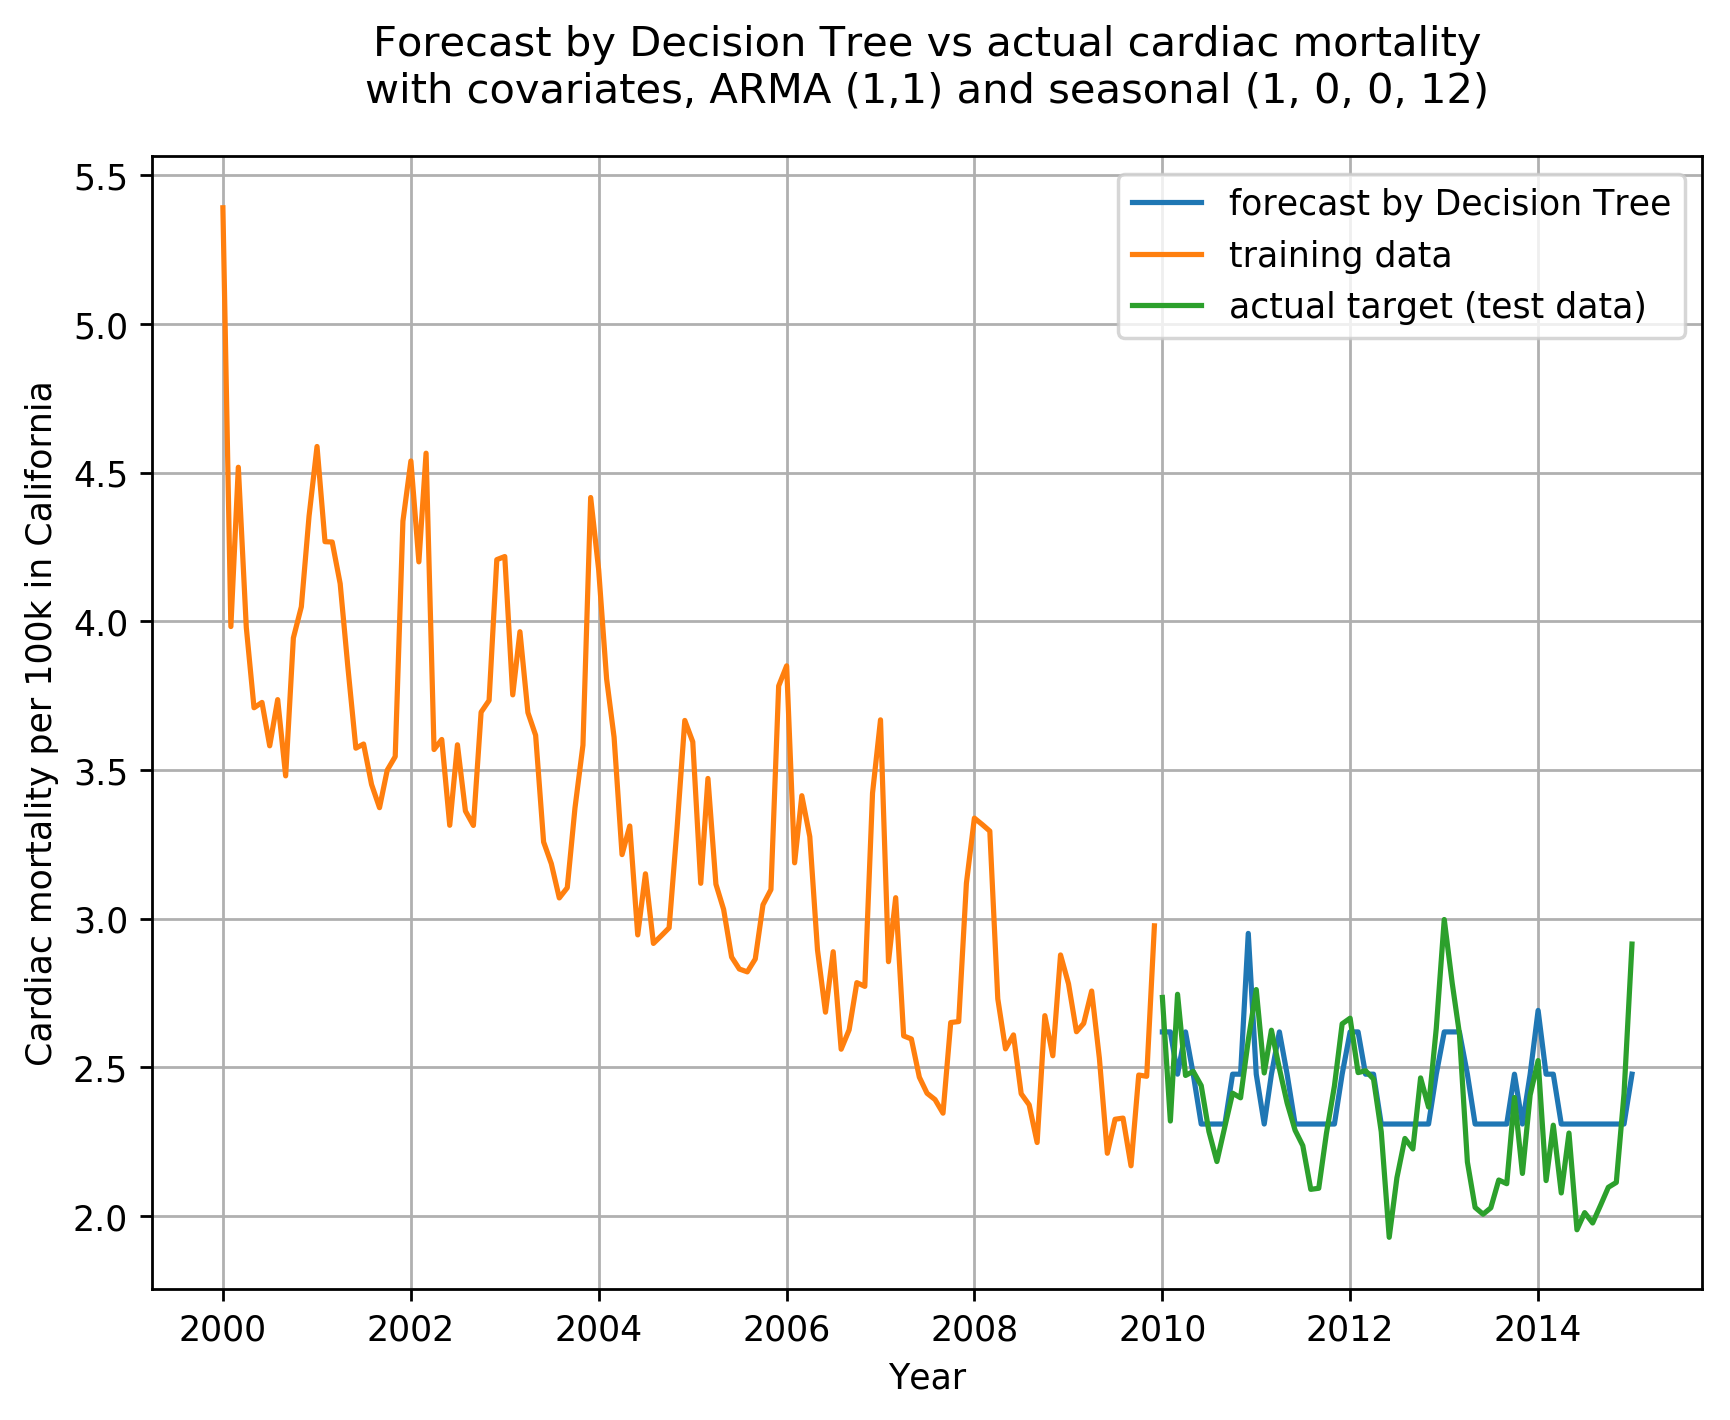

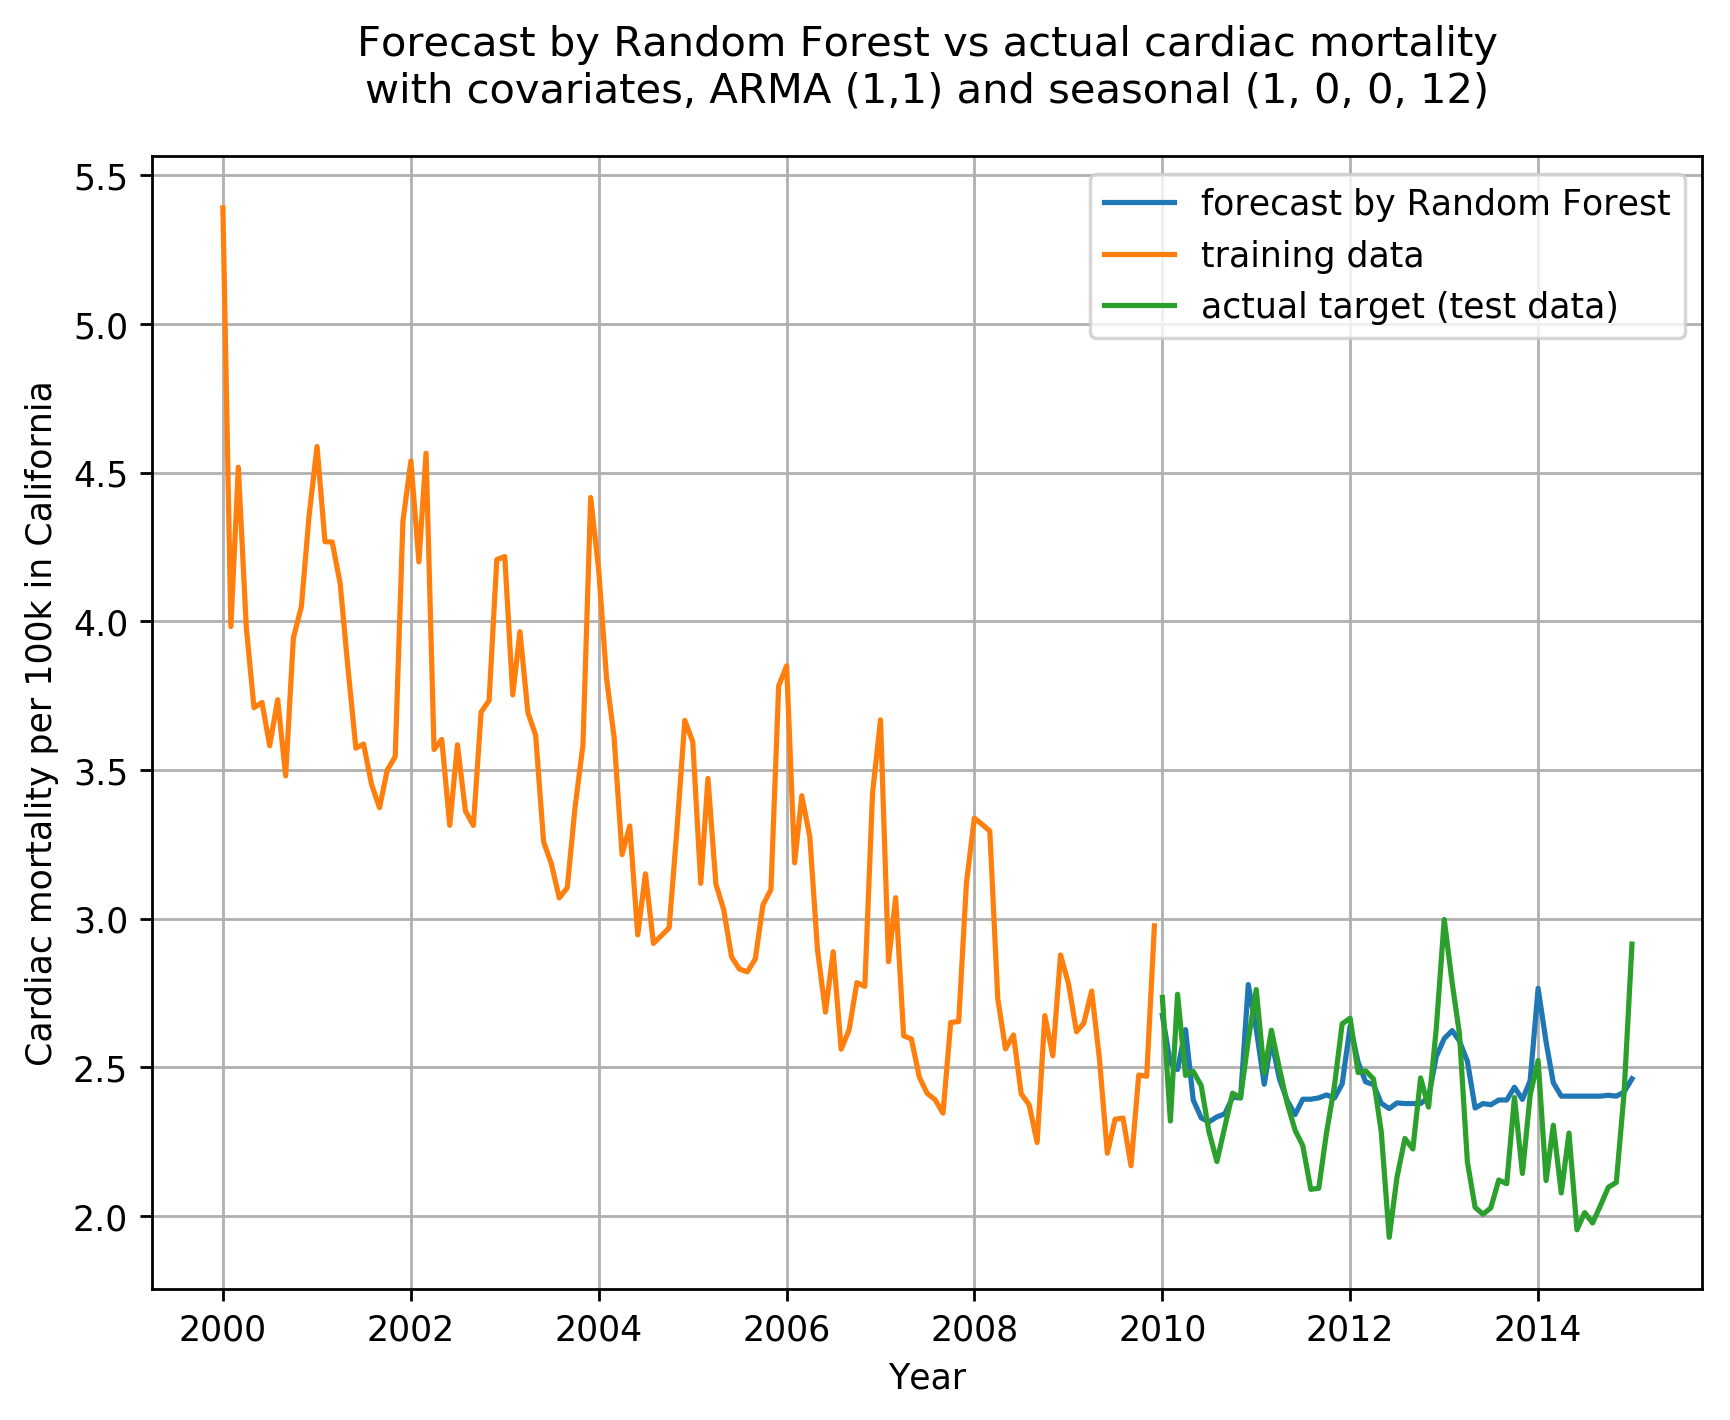

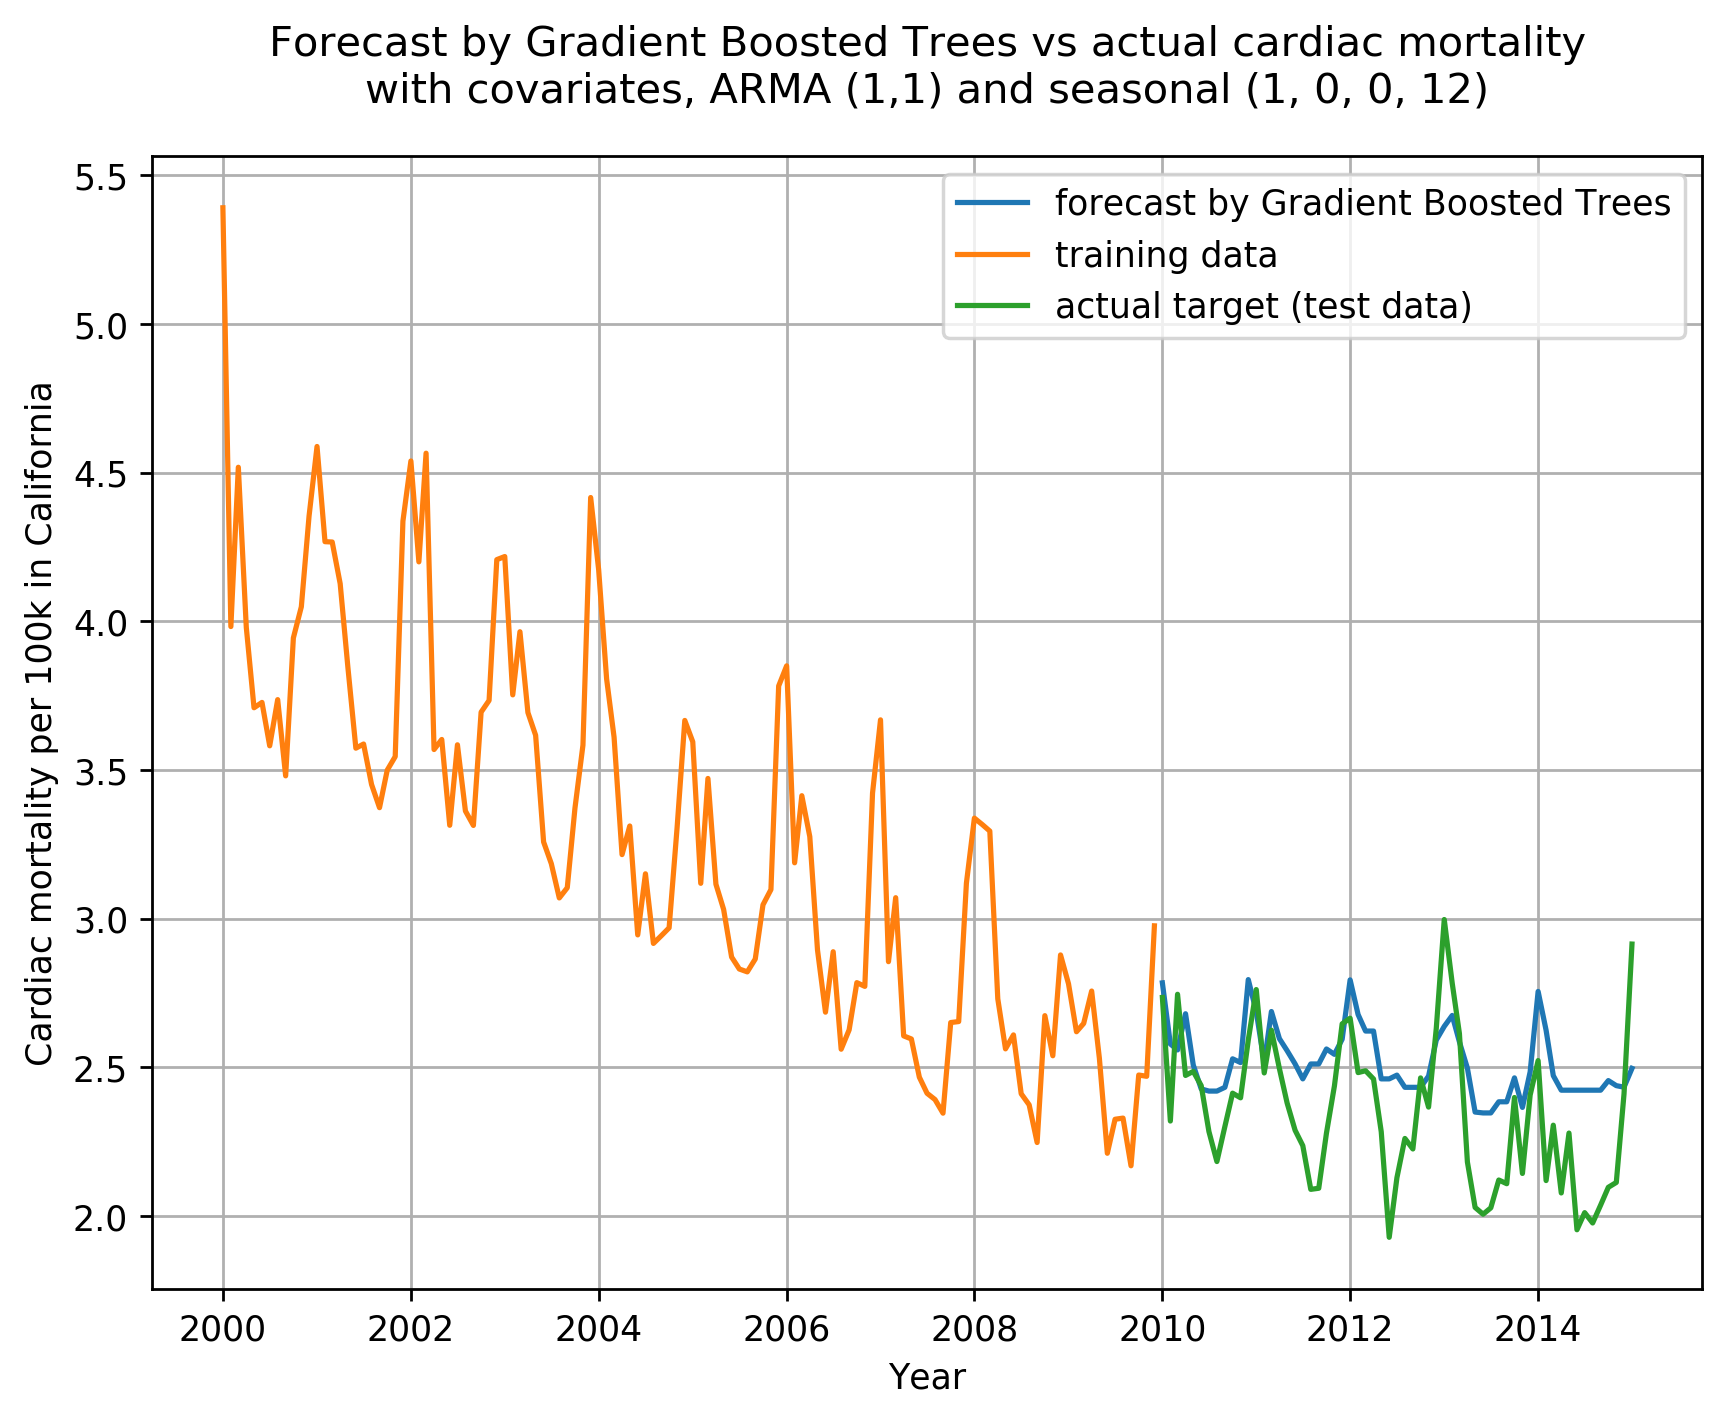

In [91]:
for model_name, model in grids.items():
    california_forecast = model.predict(california_X_test_scaled)
    california_forecast = pd.Series(california_forecast, index = california_y_test.index)

    plt.plot(california_forecast, label=f'forecast by {model_name}')
    plt.plot(california_y_train, label='training data')
    plt.plot(california_y_test, label='actual target (test data)')

    plt.xlabel('Year')
    plt.ylabel('Cardiac mortality per 100k in California')
    plt.title(f'Forecast by {model_name} vs actual cardiac mortality\nwith covariates, ARMA (1,1) and seasonal (1, 0, 0, 12)', y = 1.03)

    plt.grid()
    plt.legend()
    
    file_model_name = model_name.replace(" ", "_").lower()
    
    plt.savefig(f'../figures/california_forecast_{file_model_name}_SARMA.png')
    plt.show()

Now, let's try making the target stationary and then seeing how the model does on that. In that case, our target changes from the mortality_per_100k and instead becomes the difference of mortality_per_100k from month to month; we difference once because the standard deviation of difference x1 was the lowest, compared to the raw data vs twice differencing, etc.

In [92]:
california_SARIMA_df = california_df.copy()
california_SARIMA_df['mortality_per_100k_diff'] = california_SARIMA_df['mortality_per_100k'].diff()
california_SARIMA_df['mort_per_100k_diff_lag1'] = california_SARIMA_df['mortality_per_100k_diff'].shift()
california_SARIMA_df['mort_per_100k_diff_lag_MA1'] = california_SARIMA_df['mort_per_100k_diff_lag1'].rolling(2).mean()
california_SARIMA_df['mort_per_100k_diff_seasonal_lag1'] = california_SARIMA_df['mortality_per_100k_diff'].shift(12)

In [93]:
california_SARIMA_df.dropna(inplace=True)

In [94]:
california_SARIMA_df.drop(columns=['mortality_per_100k'], inplace=True)

In [95]:
train_fraction = 0.66

train_length = math.ceil(train_fraction*california_SARIMA_df.shape[0])

california_train = california_SARIMA_df.iloc[0:train_length, :]
california_X_train = california_train.drop(columns=['mortality_per_100k_diff'])
california_y_train = california_train.mortality_per_100k_diff

california_test = california_SARIMA_df.iloc[train_length:, :]
california_X_test = california_test.drop(columns=['mortality_per_100k_diff'])
california_y_test = california_test.mortality_per_100k_diff

In [96]:
# Now, let's fit and scale X_train, and then we'll also scale X_test.

california_columns = california_X_test.columns
california_train_index = california_X_train.index
california_test_index = california_X_test.index

ssx = StandardScaler()

california_X_train_scaled = ssx.fit_transform(california_X_train)
california_X_test_scaled = ssx.transform(california_X_test)

california_X_train_scaled = pd.DataFrame(california_X_train_scaled, columns=california_columns, index =california_train_index)
california_X_test_scaled = pd.DataFrame(california_X_test_scaled, columns=california_columns, index=california_test_index)

In [97]:
models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
test_rmse = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    
    grid.fit(california_X_train_scaled, california_y_train)
    
    california_y_test_predict = grid.predict(california_X_test_scaled)
    
    test_mse_score = -1.0*grid.score(california_X_test_scaled, california_y_test)
    test_rmse_score = np.sqrt(test_mse_score)
    
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}\ntest rmse: {test_rmse_score}\n"
        
    grids[name] = grid
    test_rmse[name] = test_rmse_score
    
    print(f'Model name: {name}')
    print(s)

Model name: Linear Regresion
Linear Regresion: best score: -4.7635666989810976e+26, best estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
test rmse: 66554805587731.3

Model name: SVR
SVR: best score: -0.0876422069035015, best estimator: SVR(C=1.0990000000000002, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
test rmse: 0.20505862394329383

Model name: Decision Tree
Decision Tree: best score: -0.07091537522297686, best estimator: DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
test rmse: 0.2507248164798591

Model name: Random Forest
Random Forest: best score: -0.06503656513165301, best estimator: Rando

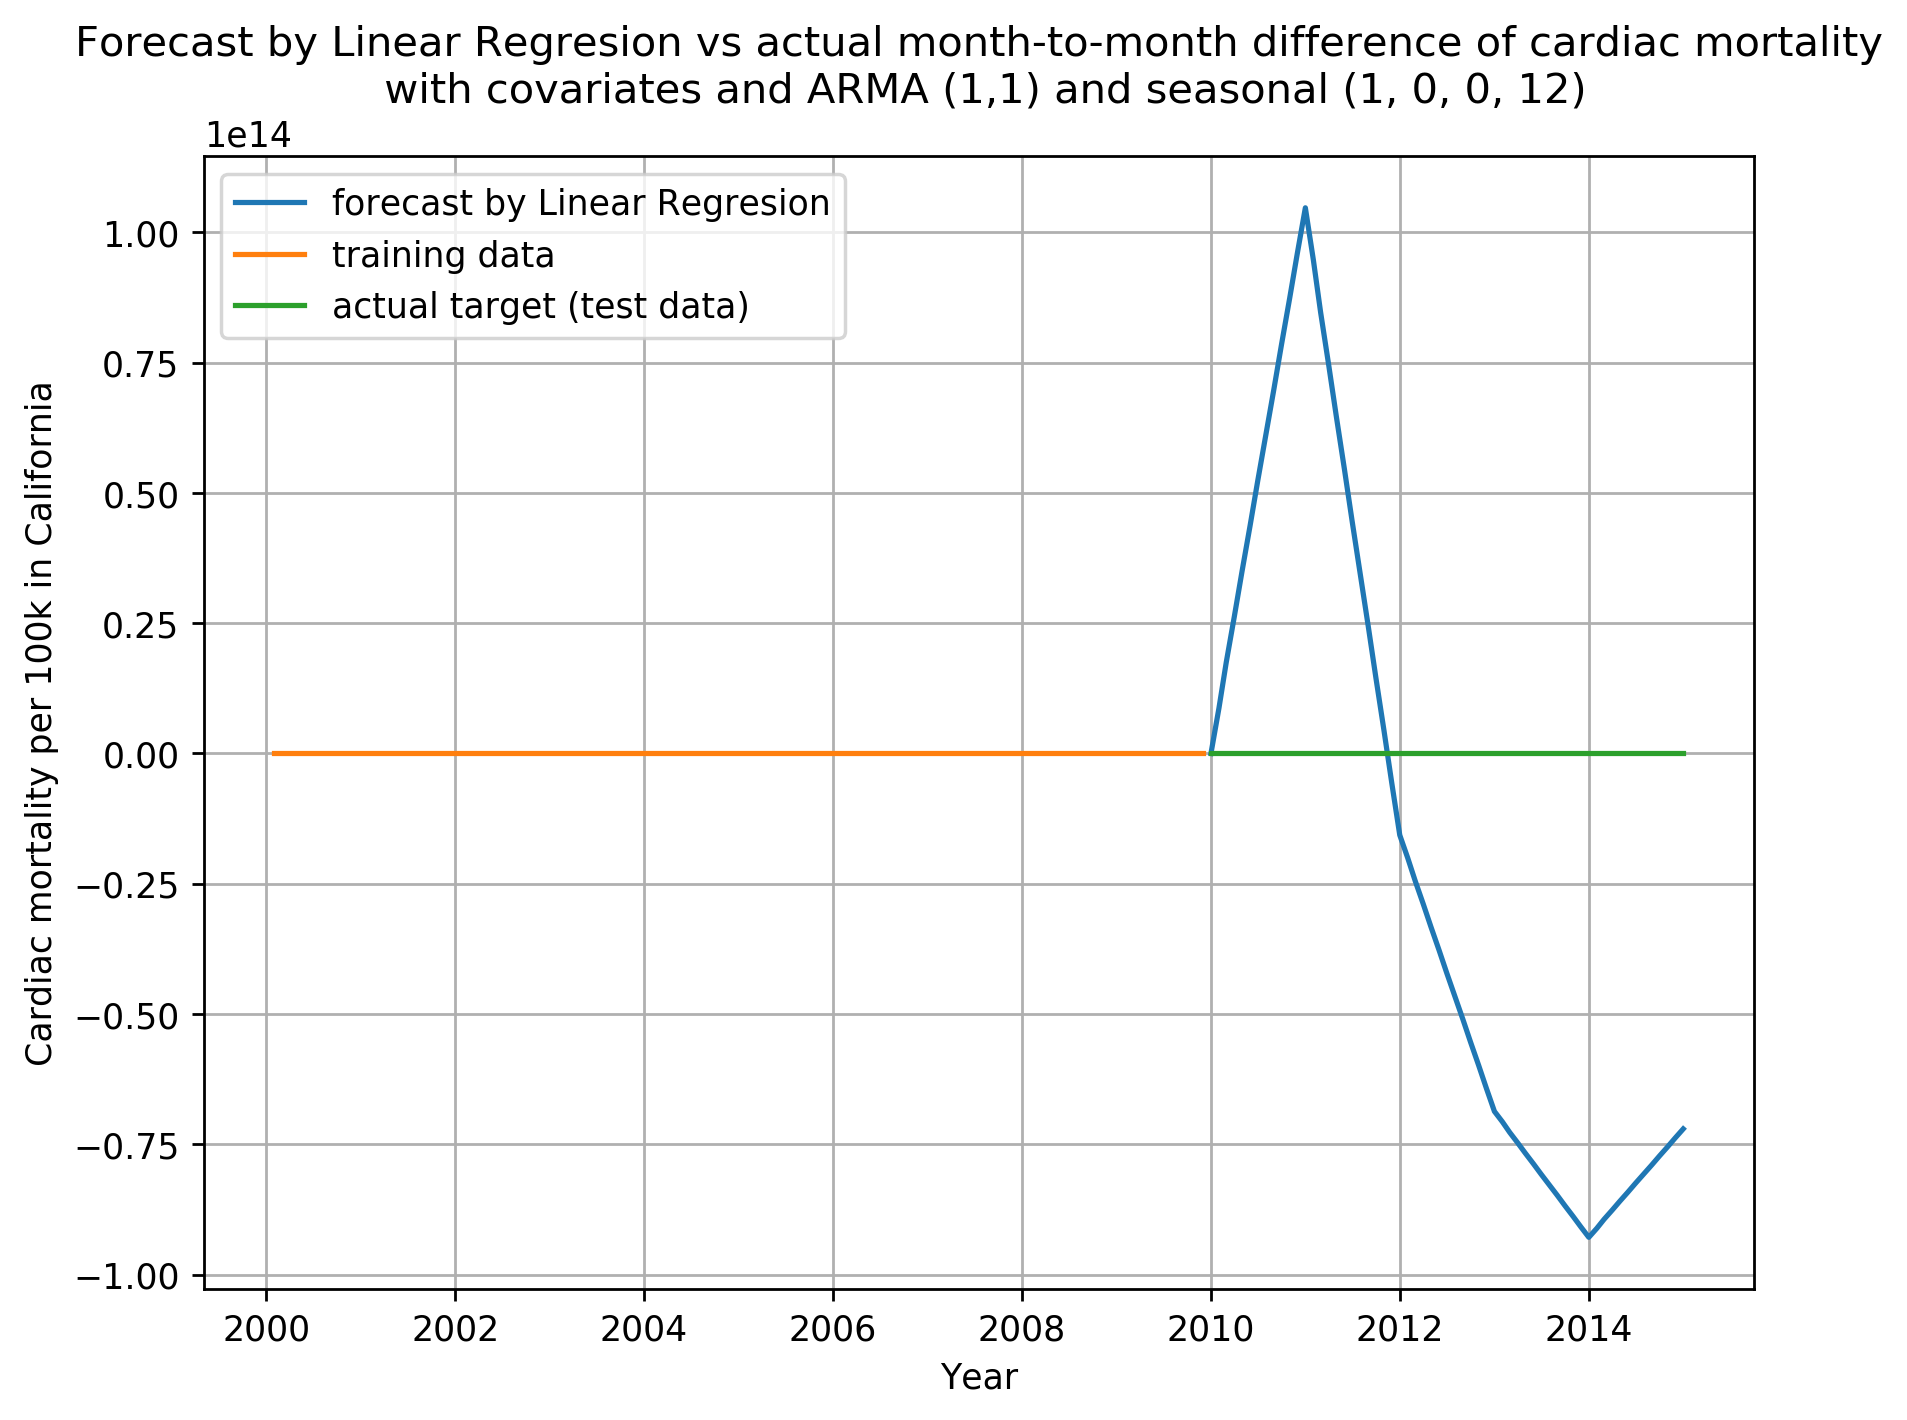

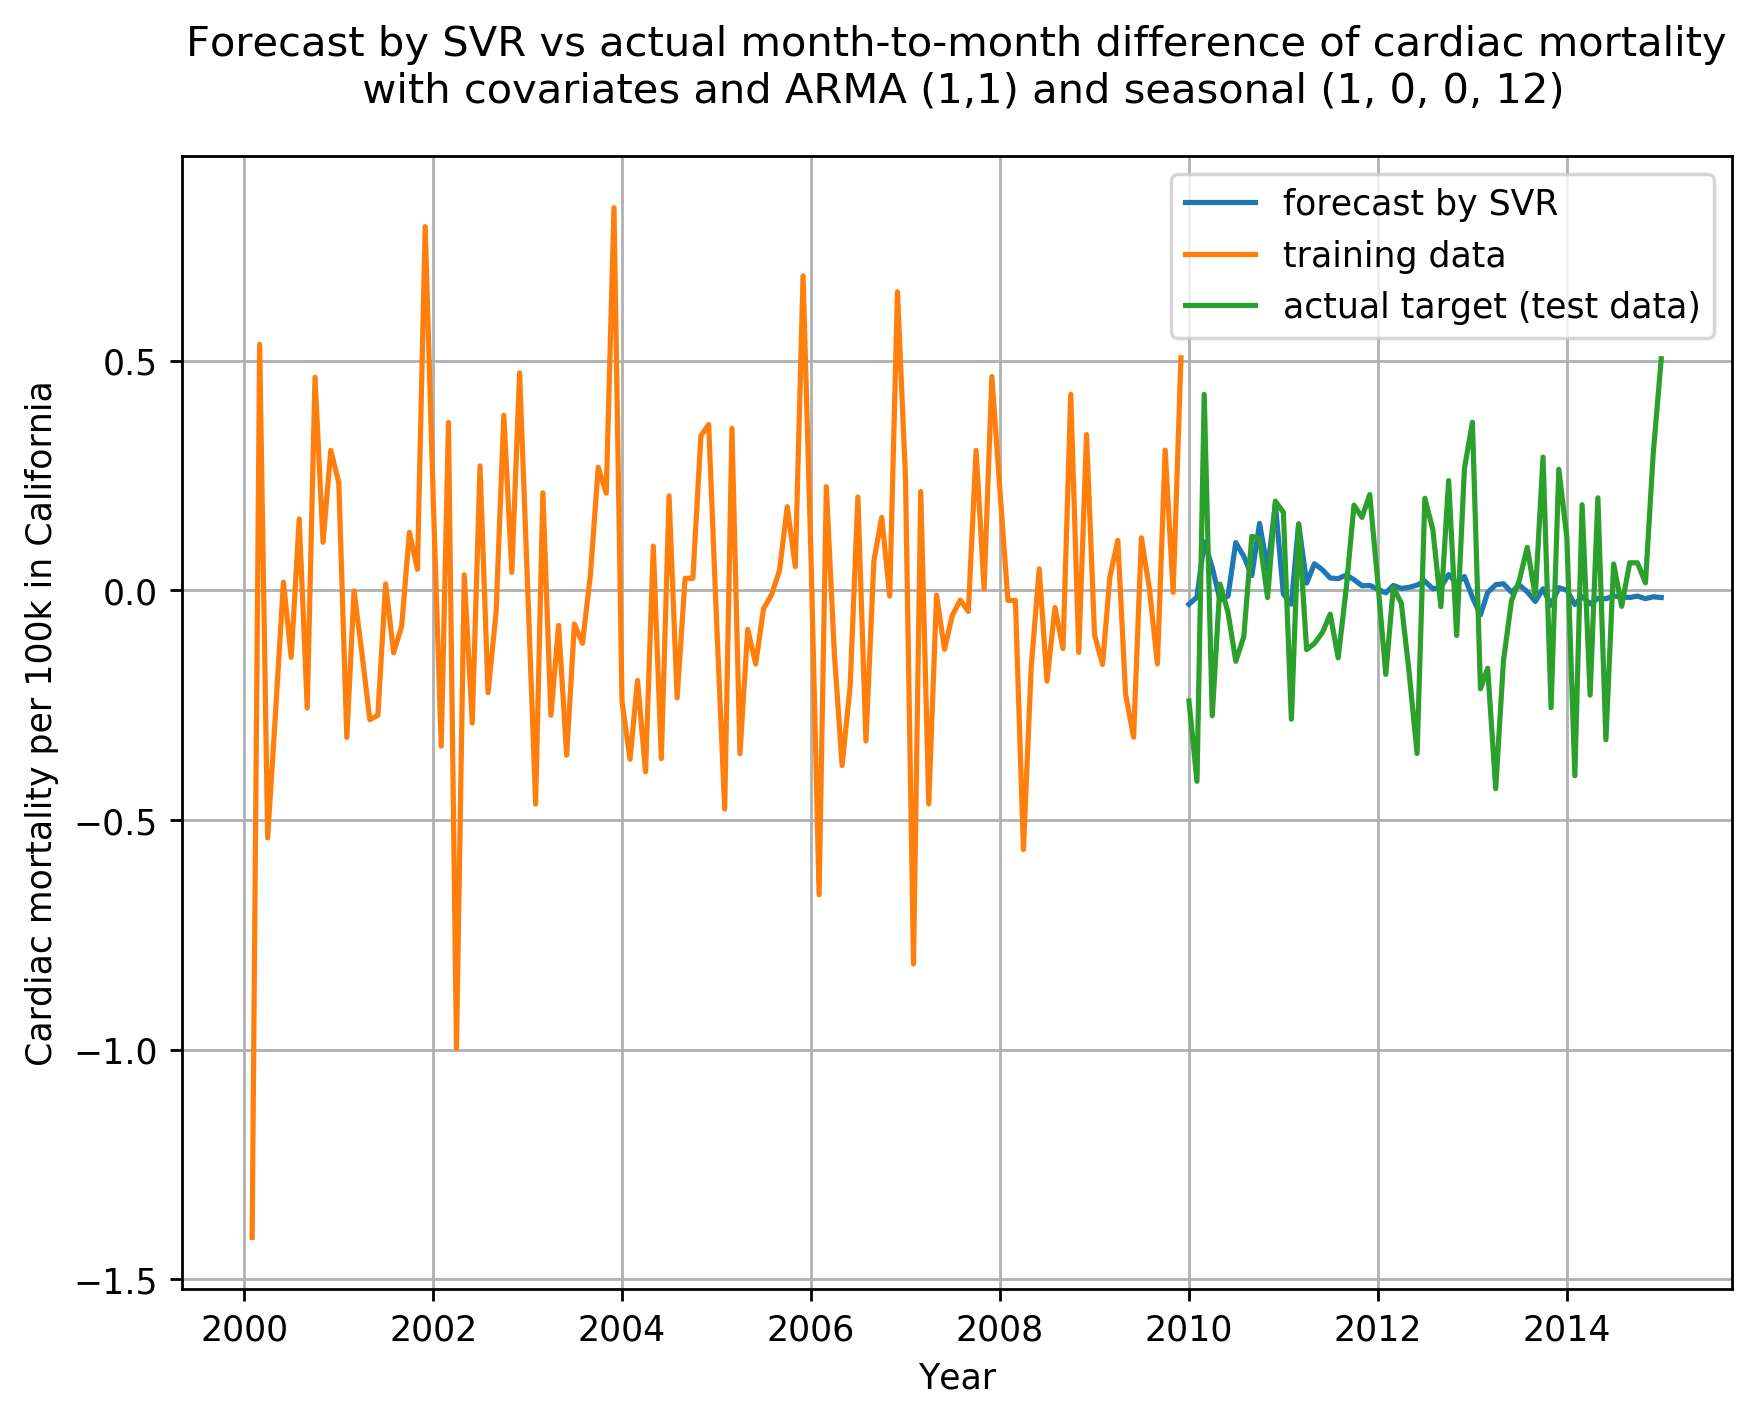

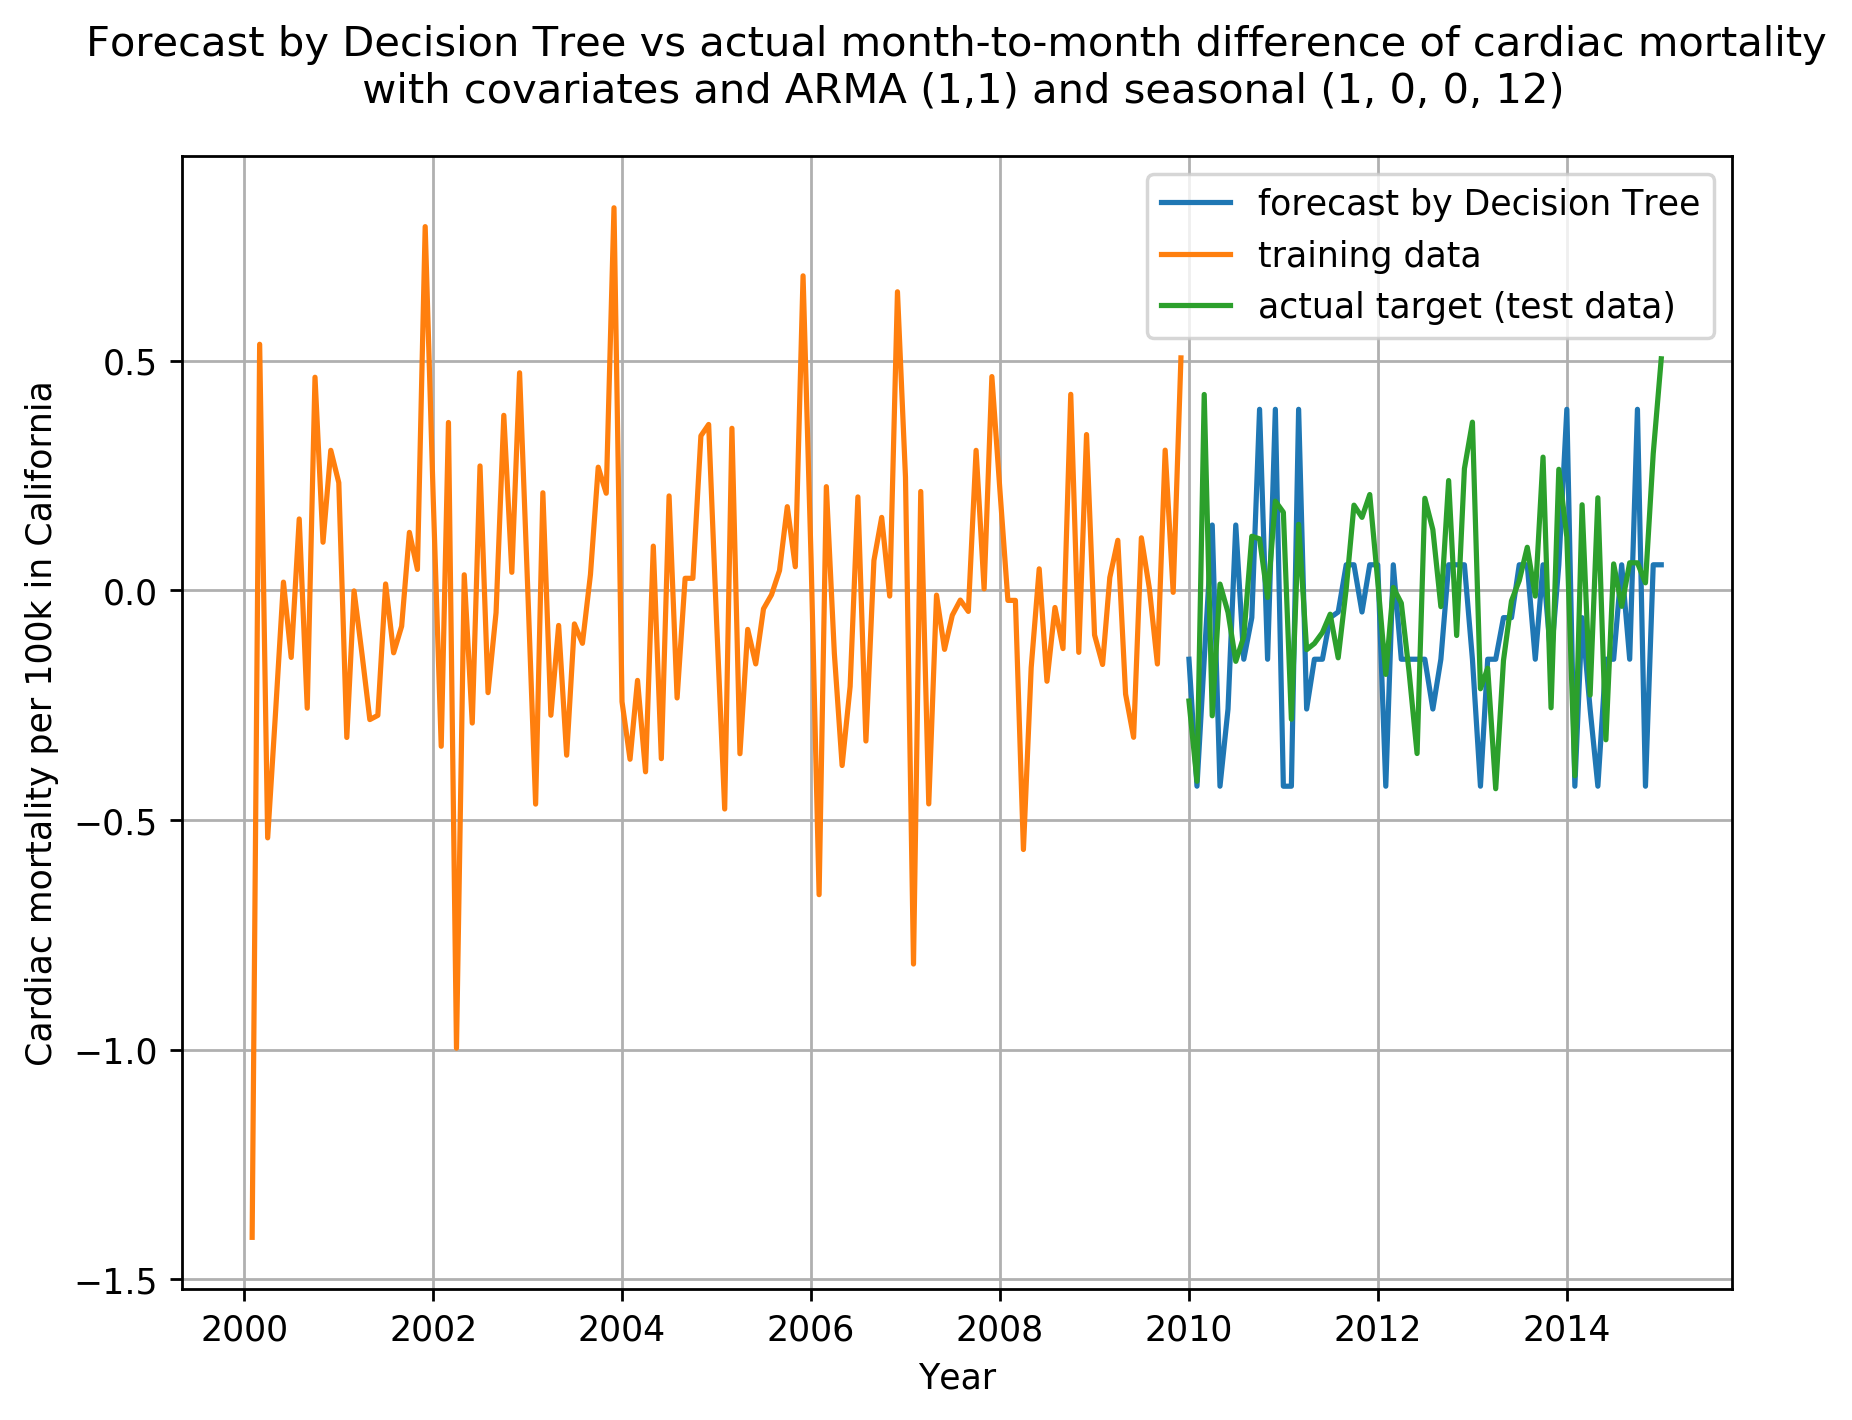

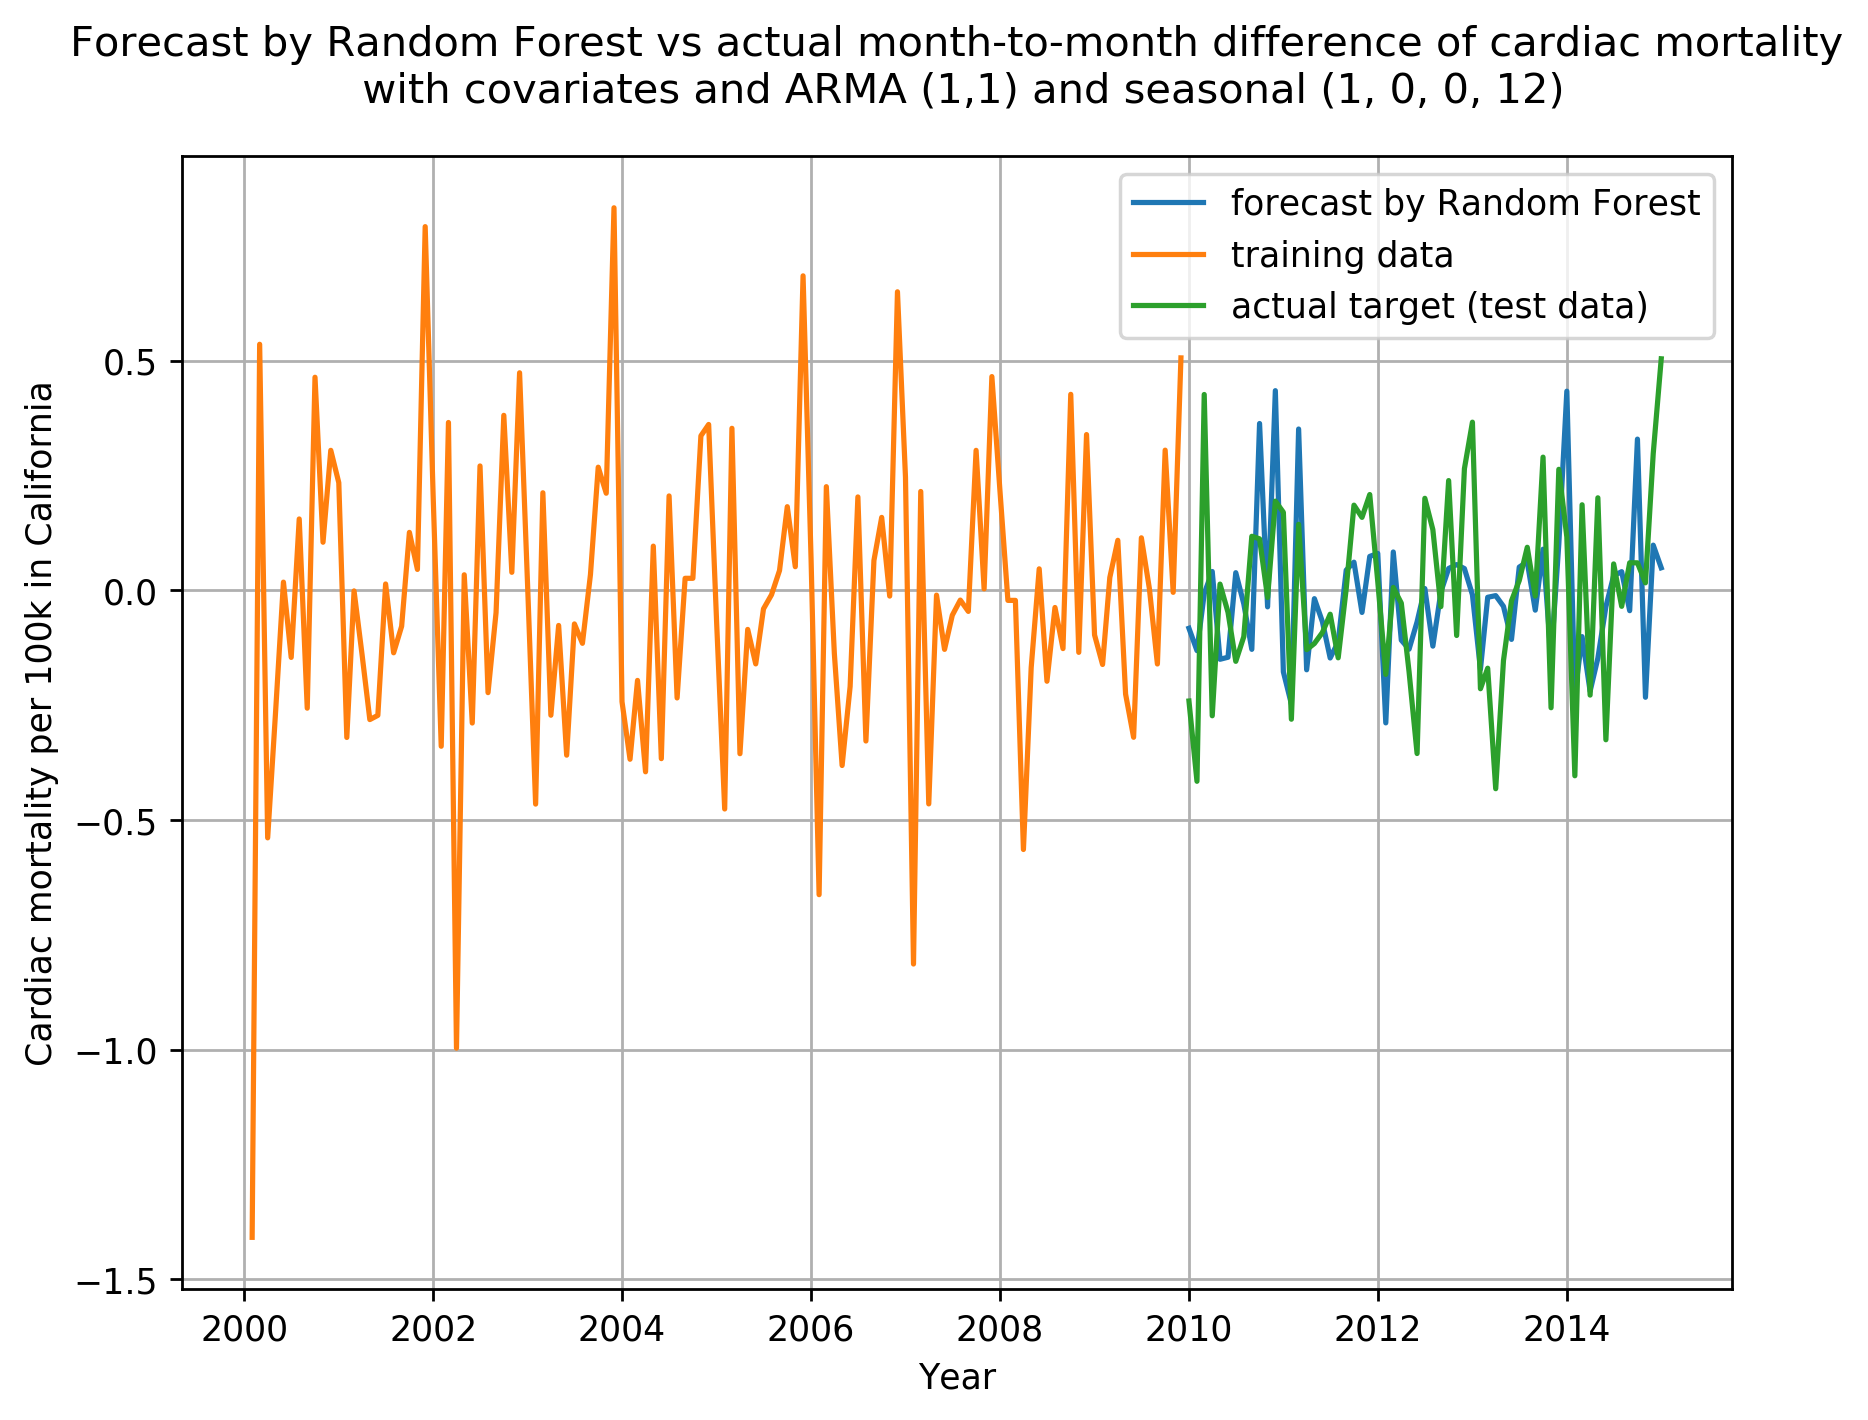

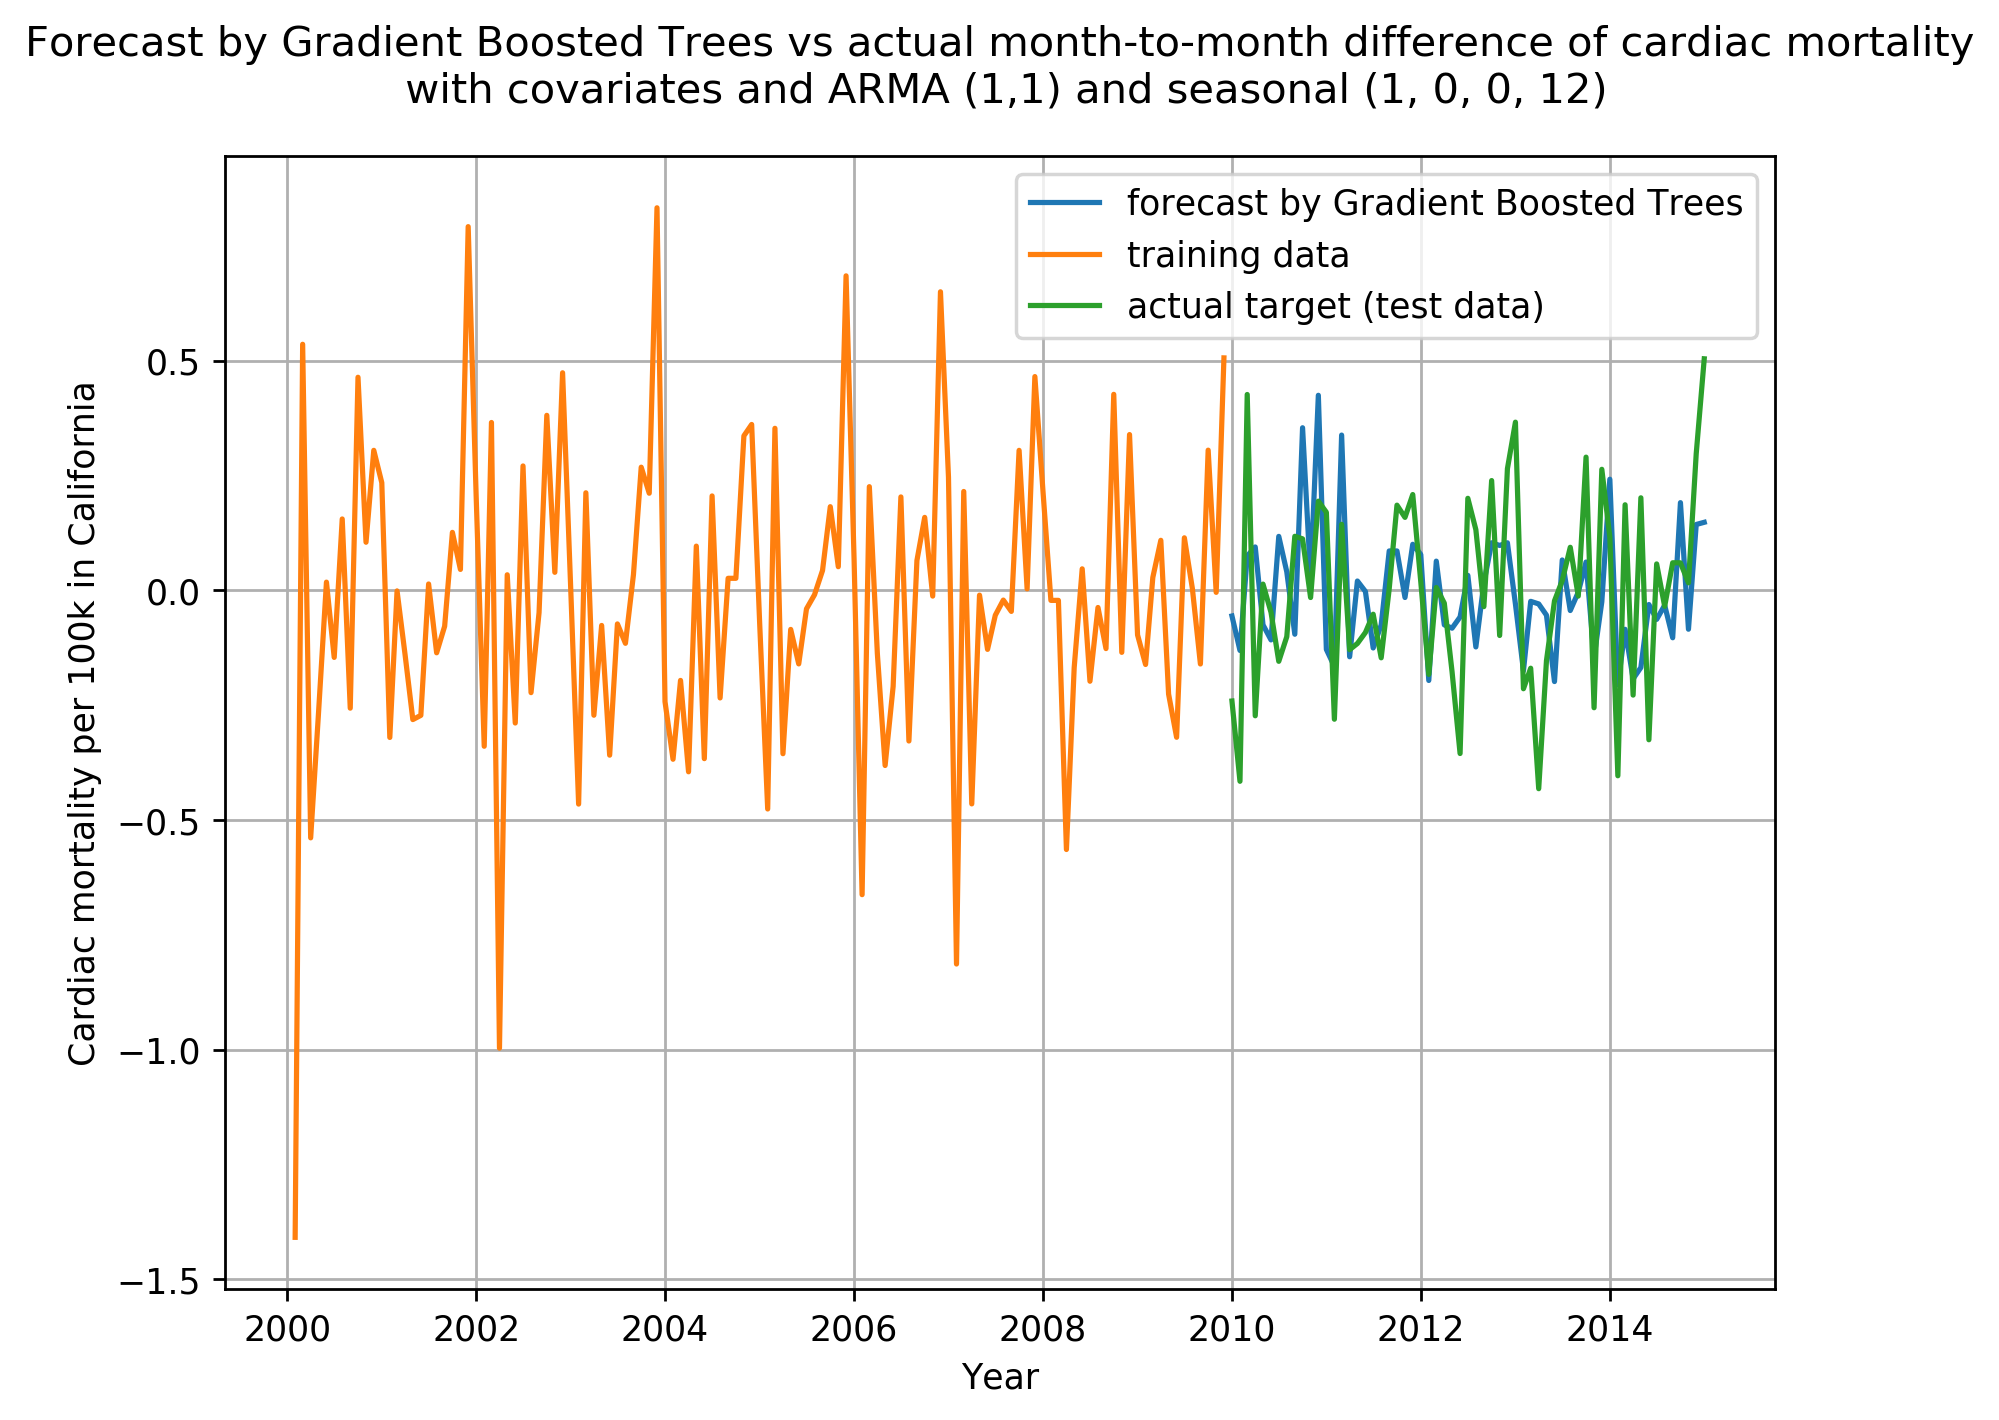

In [101]:
for model_name, model in grids.items():
    california_forecast = model.predict(california_X_test_scaled)
    california_forecast = pd.Series(california_forecast, index = california_y_test.index)

    plt.plot(california_forecast, label=f'forecast by {model_name}')
    plt.plot(california_y_train, label='training data')
    plt.plot(california_y_test, label='actual target (test data)')

    plt.xlabel('Year')
    plt.ylabel('Cardiac mortality per 100k in California')
    plt.title(f'Forecast by {model_name} vs actual month-to-month difference of cardiac mortality\n with covariates and ARMA (1,1) and seasonal (1, 0, 0, 12)', y=1.03)

    plt.grid()
    plt.legend()
    
    file_model_name = model_name.replace(" ", "_").lower()
    
    plt.savefig(f'../figures/california_forecast_{file_model_name}_SARIMA.png')
    plt.show()

In [102]:
california_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518  
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578  
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638  
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697  
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757

In [104]:
california_with_month_df = california_df.copy()

In [105]:
california_with_month_df['month'] = california_with_month_df.index.month

In [106]:
california_with_month_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  \
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518   
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578   
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638   
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697   
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757   

            month  
1999-01-01      1  
1999-02-01      2  
1999-03-01      3  
1999-04-01      4  
1999-05-01      5

In [107]:
california_with_month_df['month_squared_centered_june'] = (california_with_month_df.month - 6)**2

In [112]:
california_with_month_df.head()

obesity_prevalence  diabetes_prevalence  mortality_per_100k  \
1999-01-01           41.500000                 6.50            4.907579   
1999-02-01           41.308333                 6.55            4.744970   
1999-03-01           41.116667                 6.60            4.856788   
1999-04-01           40.925000                 6.65            4.506983   
1999-05-01           40.733333                 6.70            4.023989   

            high_cholesterol  hypertension  exercise  general_health  \
1999-01-01          0.210998      0.228108  0.212816        0.158018   
1999-02-01          0.211884      0.228286  0.217142        0.158739   
1999-03-01          0.212769      0.228463  0.221469        0.159460   
1999-04-01          0.213654      0.228641  0.225795        0.160181   
1999-05-01          0.214540      0.228819  0.230121        0.160902   

            mental_health  coverage     income    smoker  med_cost    gender  \
1999-01-01       3.234794  0.193080  40.585070  0.187049  0.111224  0.495518   
1999-02-01       3.233021  0.192317  40.847403  0.185803  0.112605  0.495578   
1999-03-01       3.231247  0.191554  41.109736  0.184557  0.113986  0.495638   
1999-04-01       3.229474  0.190790  41.372069  0.183310  0.115367  0.495697   
1999-05-01       3.227701  0.190027  41.634402  0.182064  0.116748  0.495757   

            month  month_squared_centered_june  
1999-01-01      1                           25  
1999-02-01      2                           16  
1999-03-01      3                            9  
1999-04-01      4                            4  
1999-05-01      5                            1

In [113]:
california_with_month_df.drop(columns=['month'], inplace=True)

In [119]:
train_fraction = 0.66

train_length = math.ceil(train_fraction*california_with_month_df.shape[0])

california_train = california_with_month_df.iloc[0:train_length, :]
california_X_train = california_train.drop(columns=['mortality_per_100k'])
california_y_train = california_train.mortality_per_100k

california_test = california_with_month_df.iloc[train_length:, :]
california_X_test = california_test.drop(columns=['mortality_per_100k'])
california_y_test = california_test.mortality_per_100k

In [122]:
# Now, let's fit and scale X_train, and then we'll also scale X_test.

california_columns = california_X_test.columns
california_train_index = california_X_train.index
california_test_index = california_X_test.index

ssx = StandardScaler()

california_X_train_scaled = ssx.fit_transform(california_X_train)
california_X_test_scaled = ssx.transform(california_X_test)

california_X_train_scaled = pd.DataFrame(california_X_train_scaled, columns=california_columns, index =california_train_index)
california_X_test_scaled = pd.DataFrame(california_X_test_scaled, columns=california_columns, index=california_test_index)

In [123]:
models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
test_rmse = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    
    grid.fit(california_X_train_scaled, california_y_train)
    
    california_y_test_predict = grid.predict(california_X_test_scaled)
    
    test_mse_score = -1.0*grid.score(california_X_test_scaled, california_y_test)
    test_rmse_score = np.sqrt(test_mse_score)
    
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}\ntest rmse: {test_rmse_score}\n"
        
    grids[name] = grid
    test_rmse[name] = test_rmse_score
    
    print(f'Model name: {name}')
    print(s)

Model name: Linear Regresion
Linear Regresion: best score: -1.1333030652497274e+27, best estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
test rmse: 12905215558328.973

Model name: SVR
SVR: best score: -0.5072443463975949, best estimator: SVR(C=1.0990000000000002, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
test rmse: 1.4337901059235607

Model name: Decision Tree
Decision Tree: best score: -0.4710665389654547, best estimator: DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
test rmse: 0.6417100860753823

Model name: Random Forest
Random Forest: best score: -0.3611646323898531, best estimator: RandomF

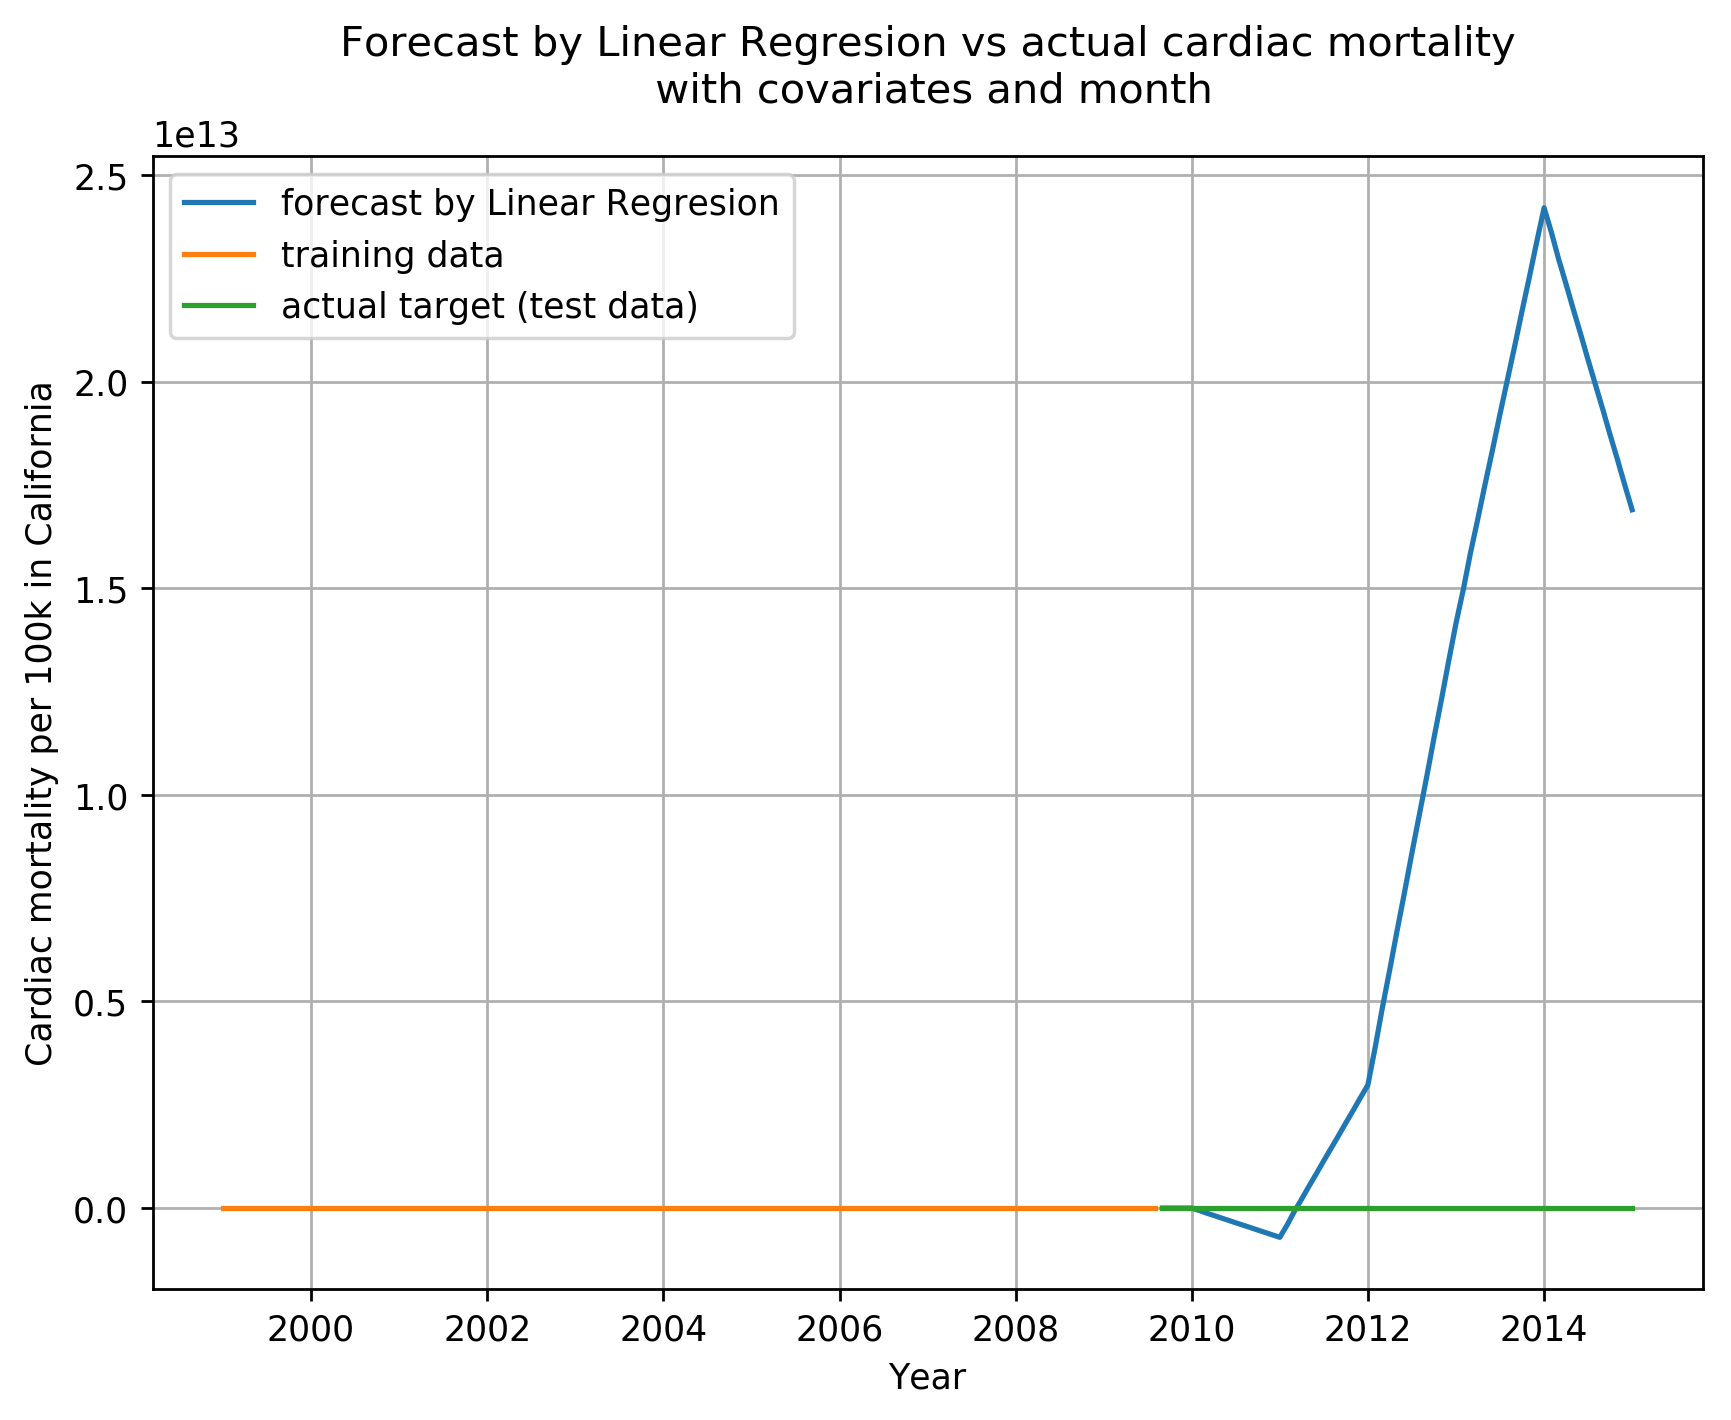

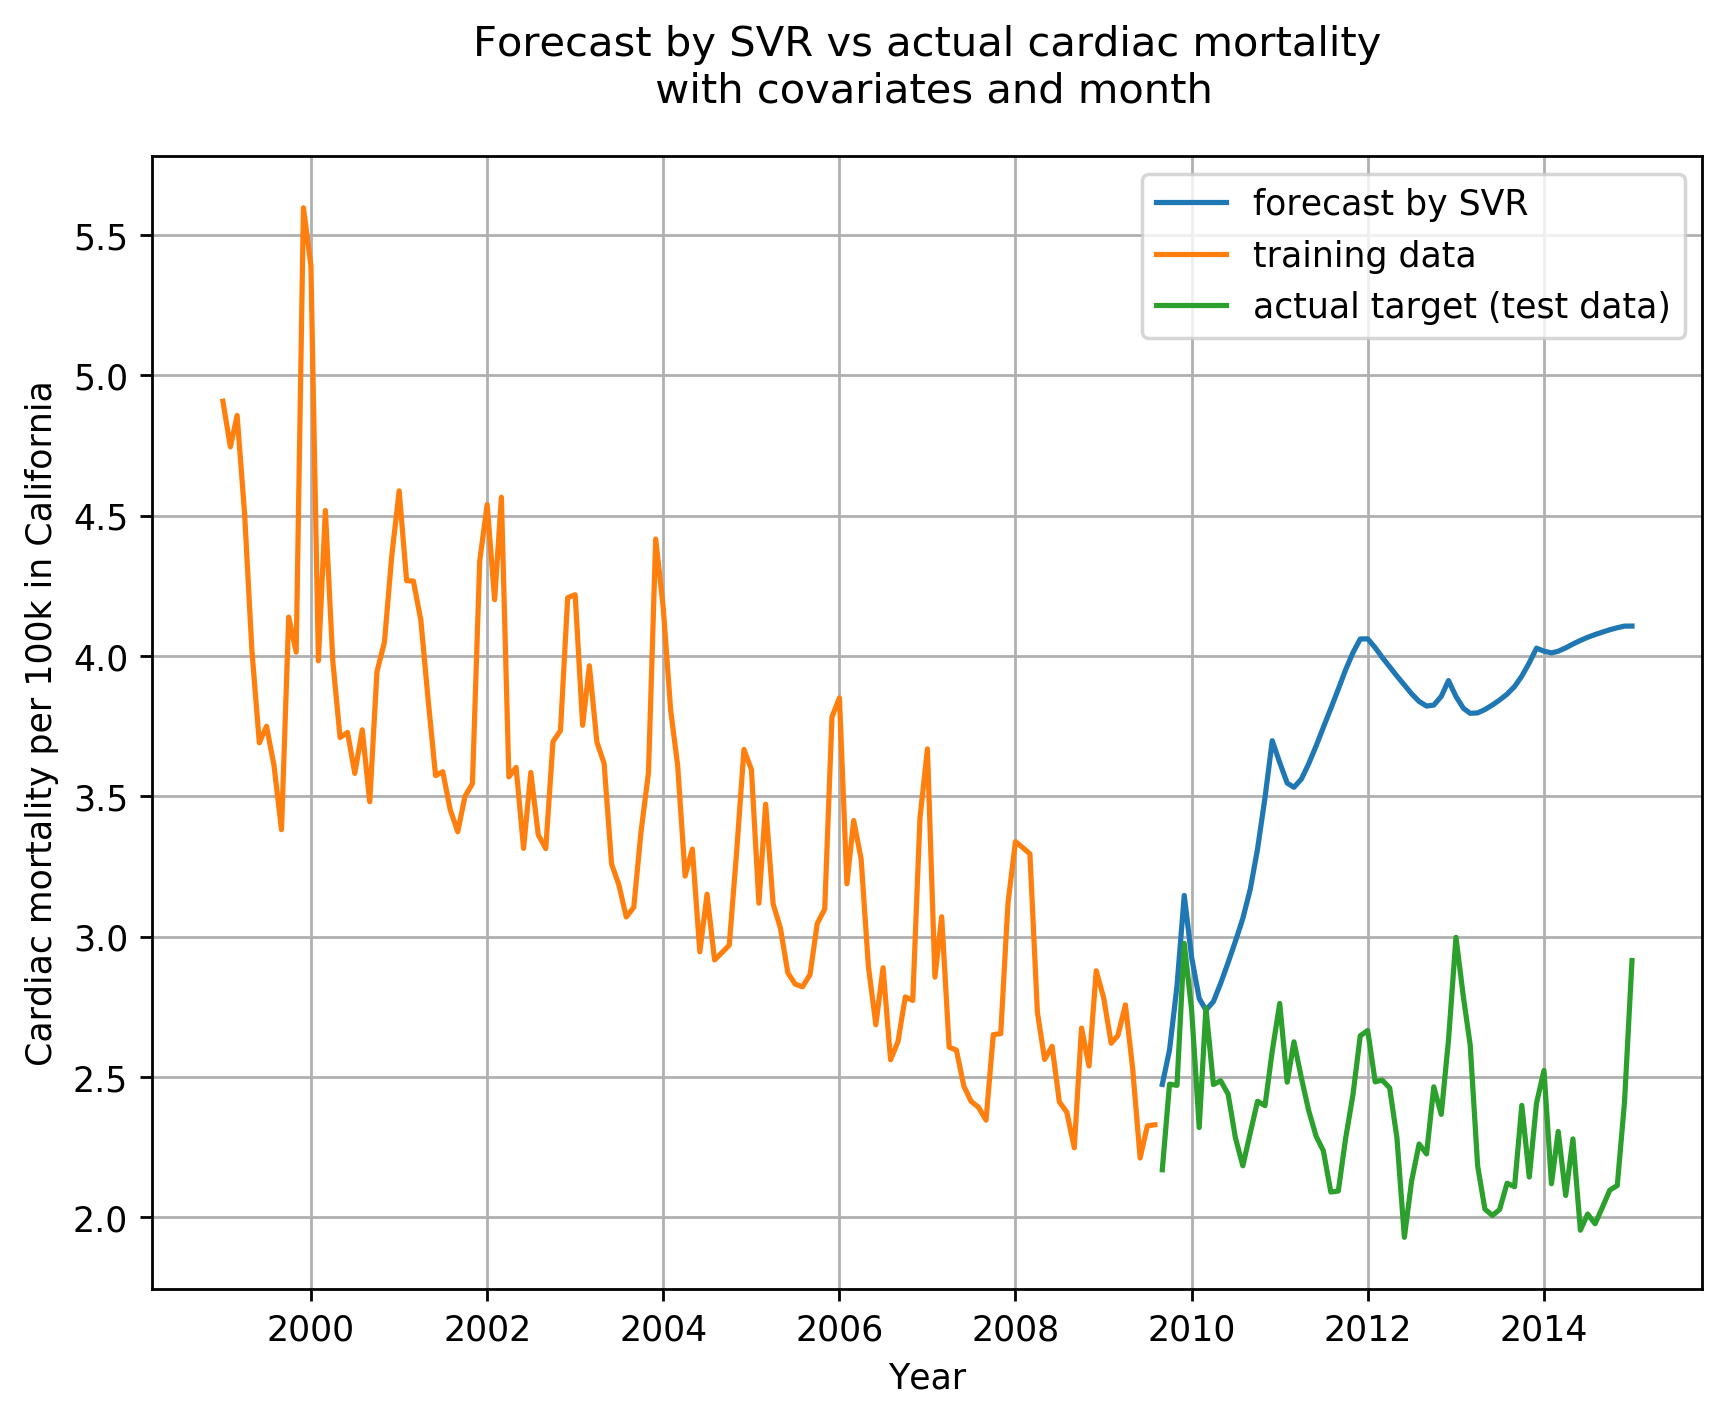

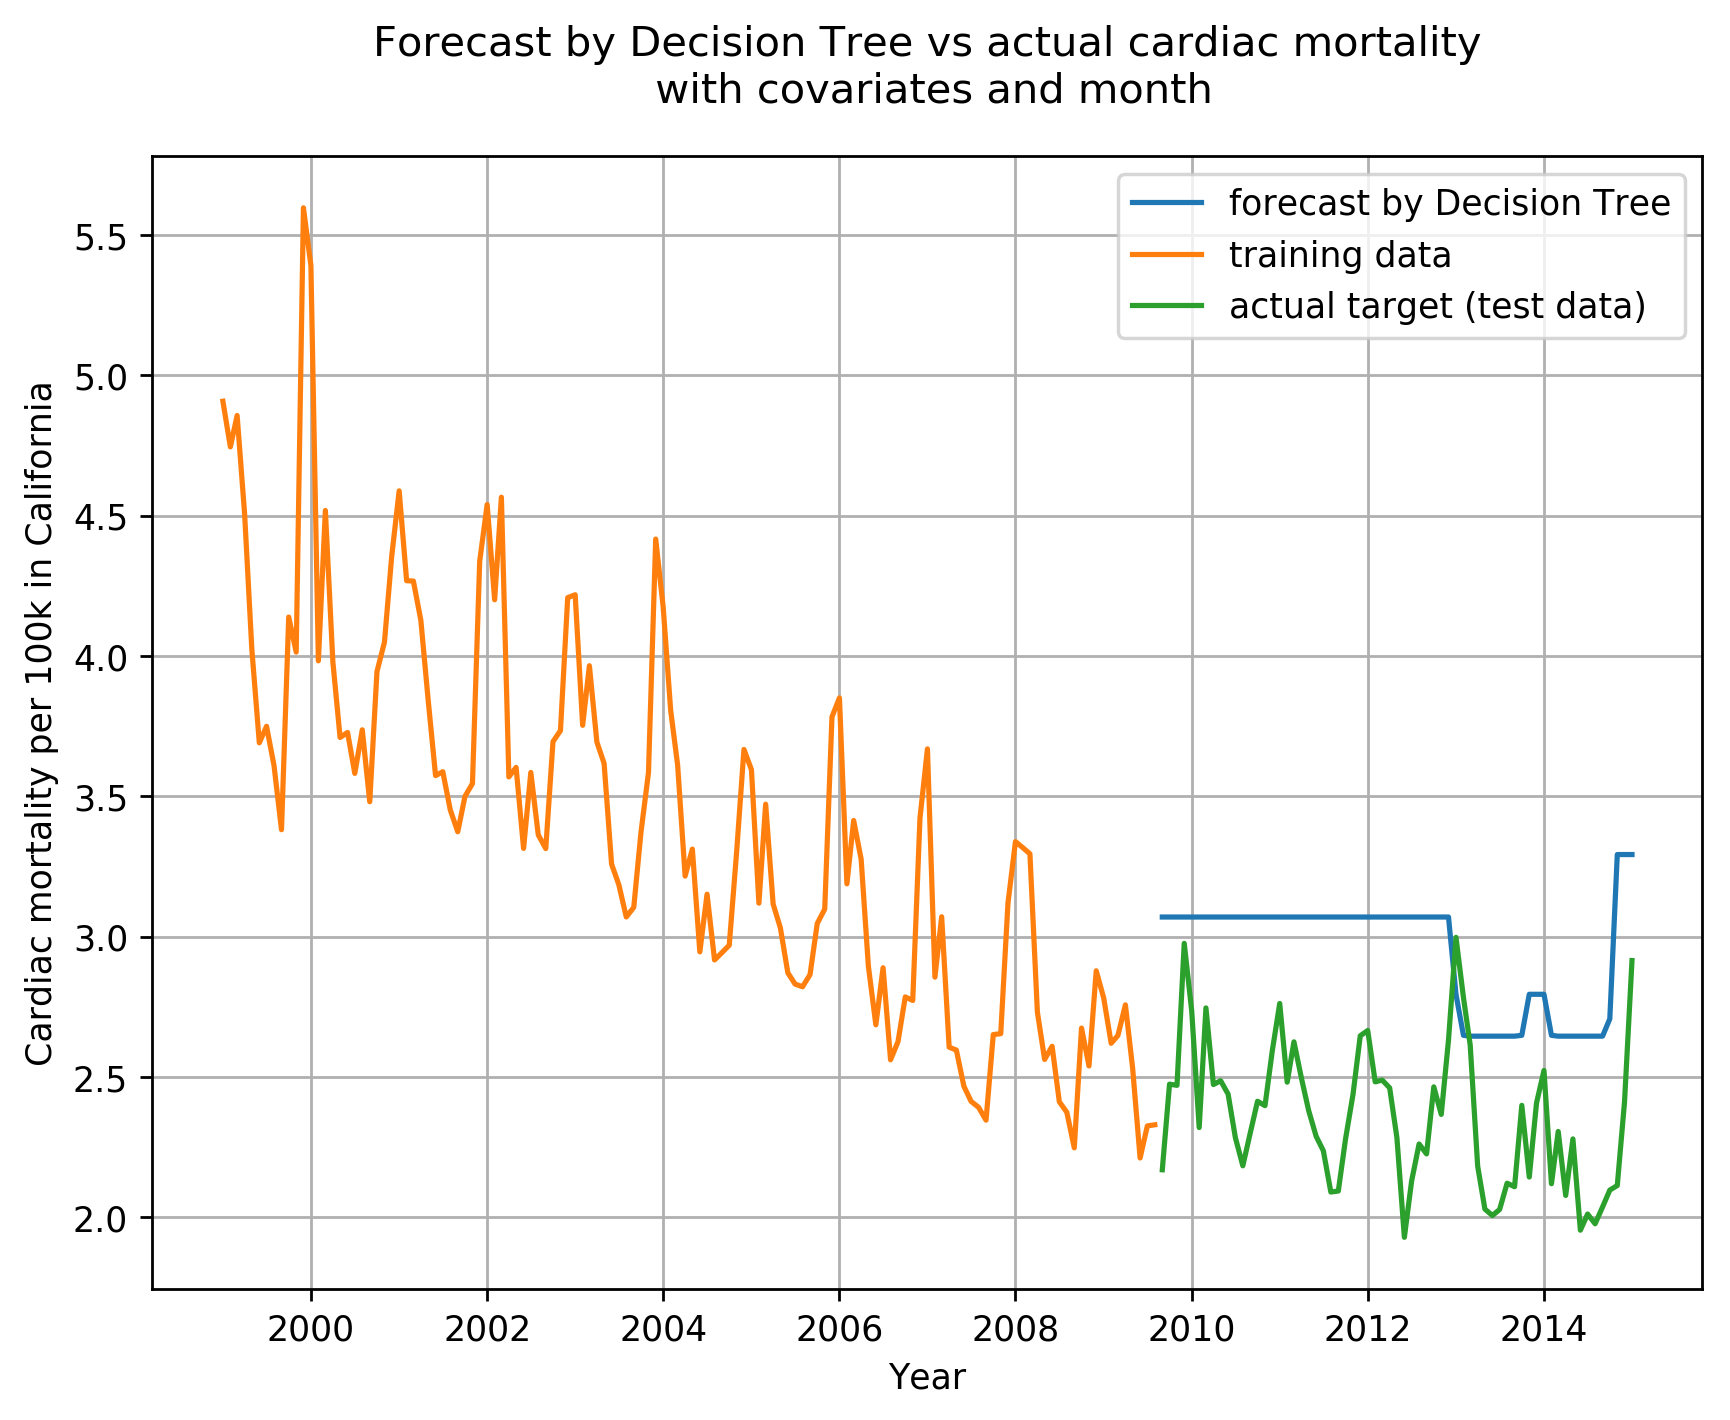

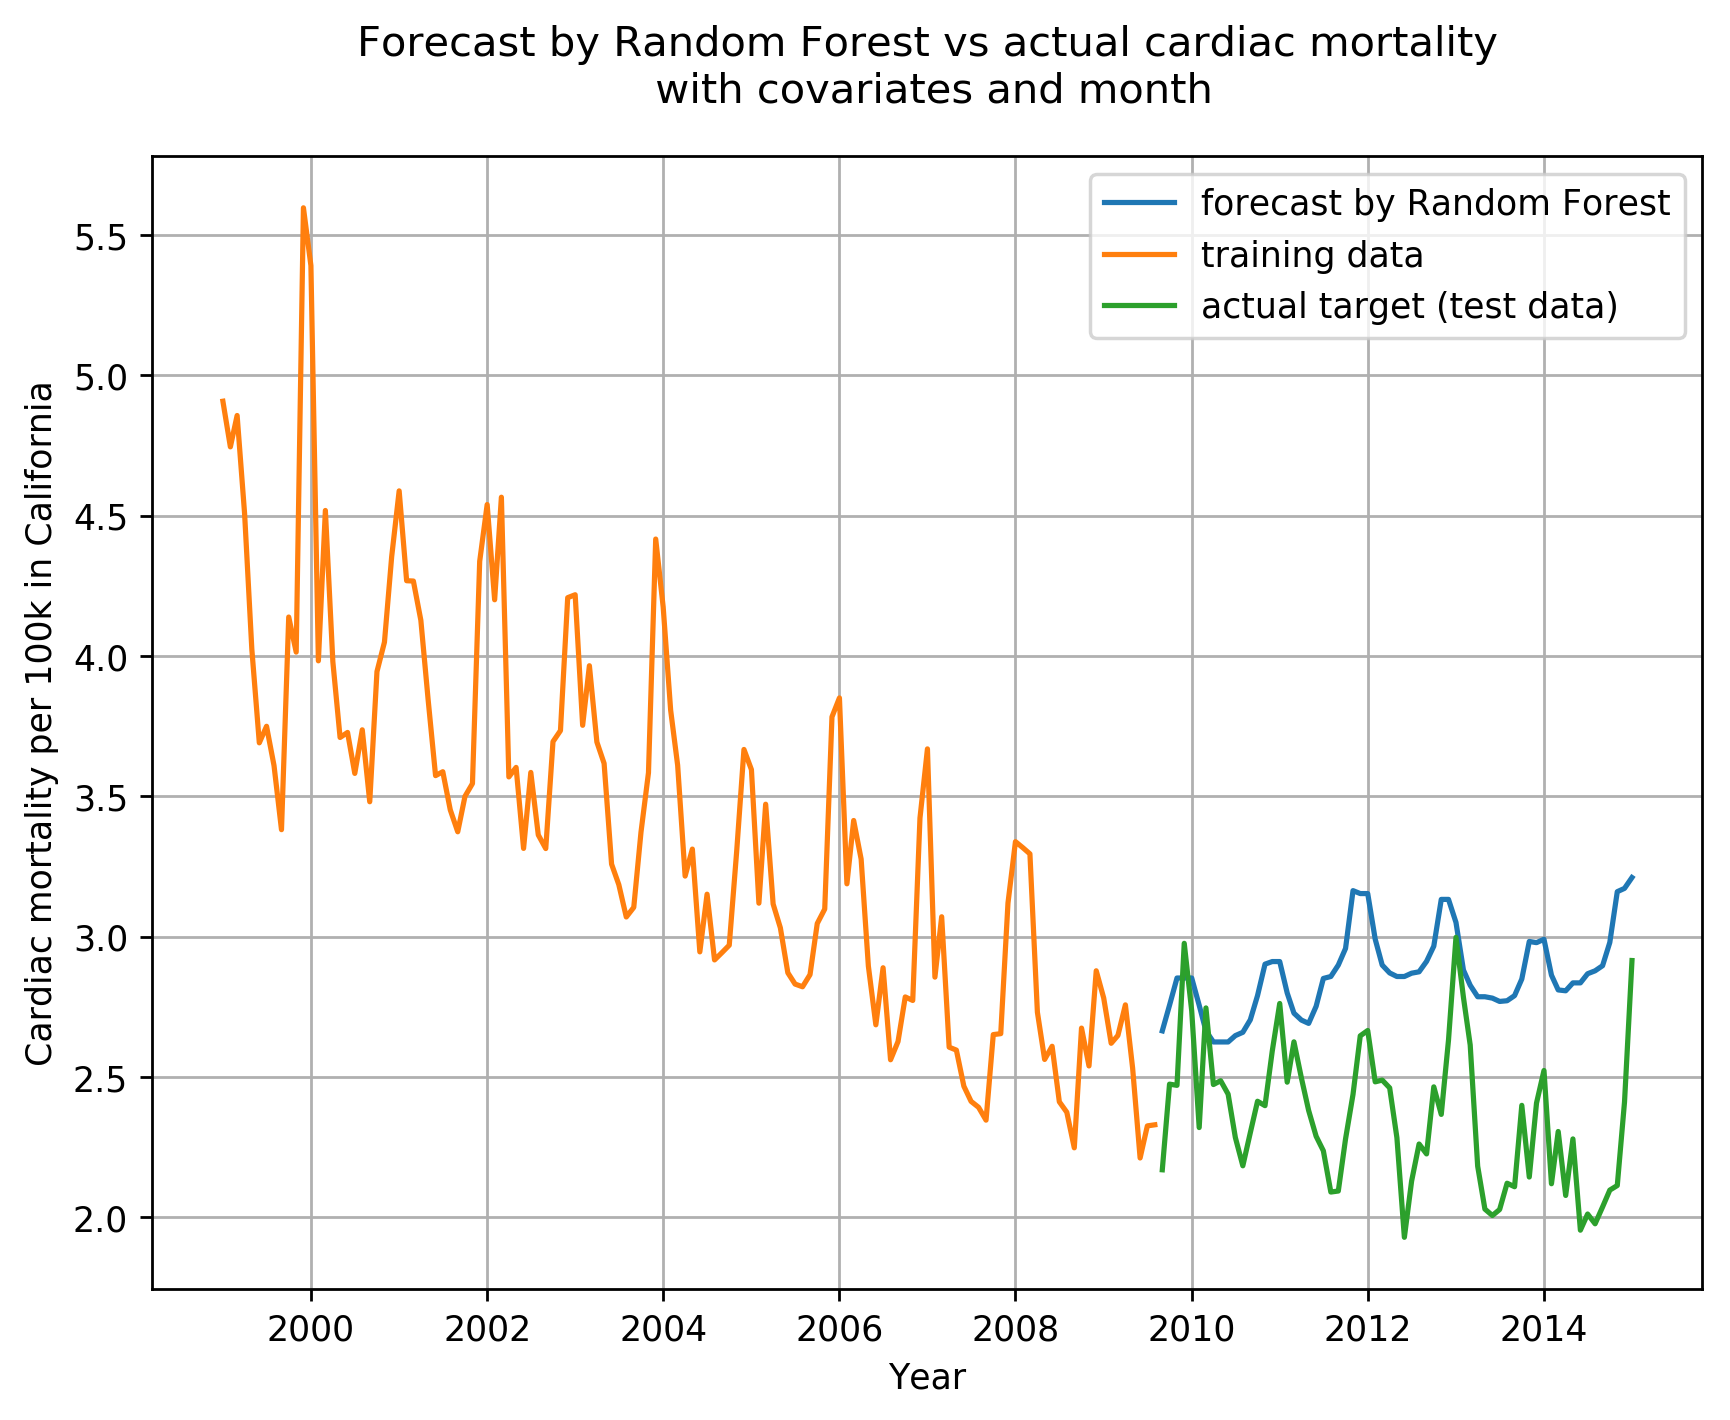

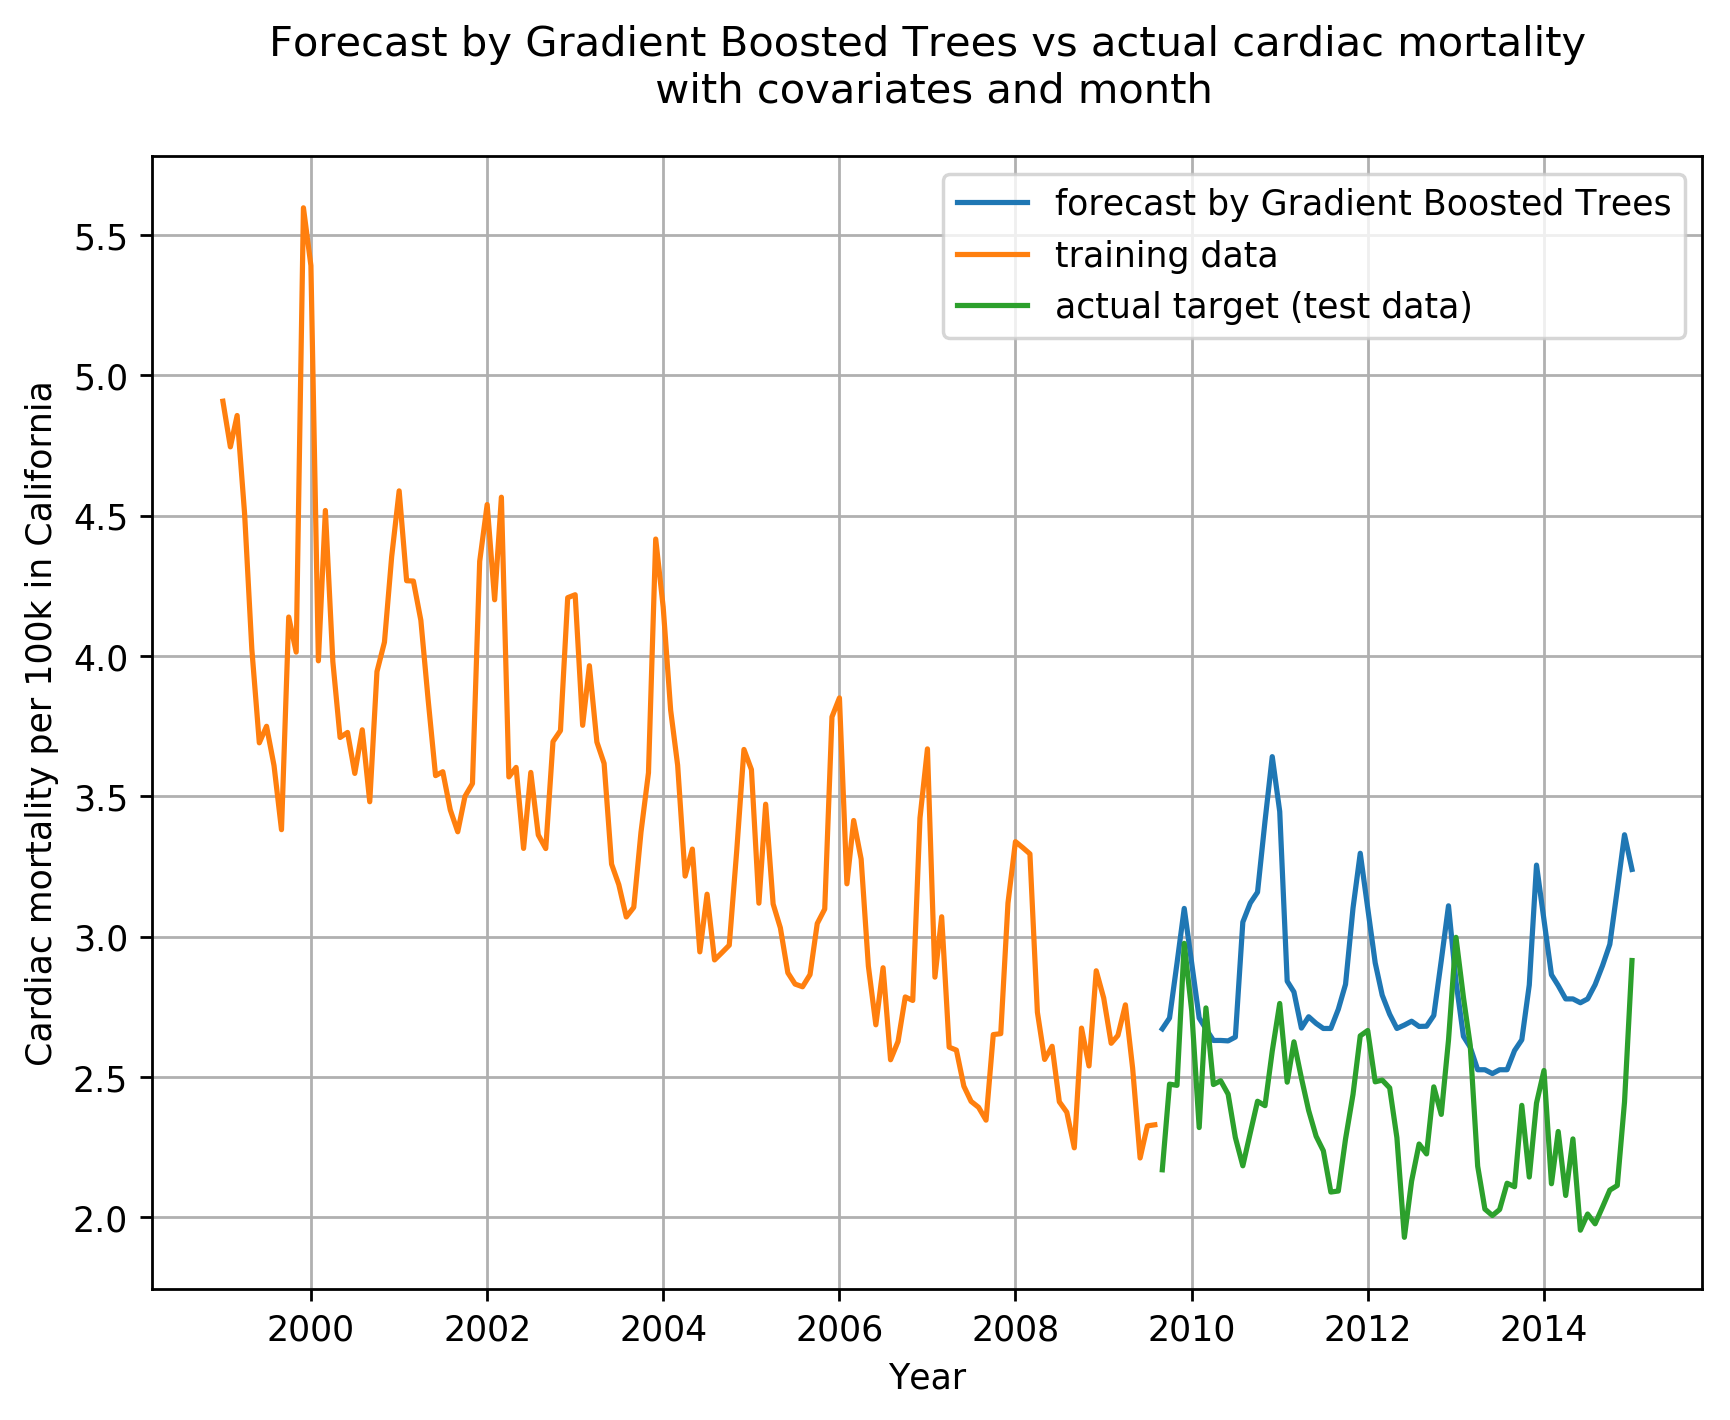

In [125]:
for model_name, model in grids.items():
    california_forecast = model.predict(california_X_test_scaled)
    california_forecast = pd.Series(california_forecast, index = california_y_test.index)

    plt.plot(california_forecast, label=f'forecast by {model_name}')
    plt.plot(california_y_train, label='training data')
    plt.plot(california_y_test, label='actual target (test data)')

    plt.xlabel('Year')
    plt.ylabel('Cardiac mortality per 100k in California')
    plt.title(f'Forecast by {model_name} vs actual cardiac mortality\n with covariates and month', y=1.03)

    plt.grid()
    plt.legend()
    
    file_model_name = model_name.replace(" ", "_").lower()
    
    plt.savefig(f'../figures/california_forecast_{file_model_name}_with_month.png')
    plt.show()